# Data Preprocessing

import

In [1]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy
import seaborn as sns
import sys
import warnings

from scipy import stats

### Demographic Data
The ADHD-200 dataset comprises neuroimaging and phenotypic data collected across multiple research sites. Due to variations in acquisition protocols, scanner parameters, and assessment methodologies between contributing institutions, the dataset exhibits significant site-specific heterogeneity. This necessitates comprehensive preprocessing, harmonization, and standardization procedures before meaningful cross-site analyses can be conducted. By implementing robust data cleaning pipelines that account for these systematic differences, researchers can mitigate site-related confounds and leverage the full statistical power of this valuable multi-site resource for investigating attention-deficit/hyperactivity disorder.

In [2]:
# Function to detect file encoding
def detect_file_encoding(file_path):
    """Detect the encoding of a file using chardet"""
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

In [3]:
def standardize_columns(data_frame, site_name):
    """

    :param data_frame:
    :param site_name:
    :return:
    """
    df = data_frame.copy()
    df['site'] = site_name

    column_mapping = {
        'participant_id': 'subject_id',
        'gender': 'gender',
        'sex': 'gender',
        'age': 'age',
        'handeness': 'handeness',
        'dx': 'diagnosis',
        'adhd': 'adhd_binary',
        'secondary_dx': 'secondary_diagnosis',
        'secondary_dx_': 'secondary_diagnosis',
        'iq_measure': 'iq_test',
        'verbal_iq': 'verbal_iq',
        'performance_iq': 'performance_iq',
        'full4_iq': 'full_scale_iq',
        'full2_iq': 'full_scale_iq_2sub',
        'adhd_measure': 'adhd_measure',
        'adhd_index': 'adhd_index',
        'inattentive': 'inattentive_score',
        'hyper_impulsive': 'hyperactive_impulsive_score',
        'med_status': 'medication_status',
        'qc_rest_1': 'qc_rest_1',
        'qc_anatomical_1': 'qc_anatomical_1'
    }

    # Rename columns based on mapping, but only if they exist in the dataframe
    rename_dict = {col: new_col for col, new_col in column_mapping.items()
                   if col in df.columns}
    df = df.rename(columns=rename_dict)

    essential_columns = ['subject_id', 'gender', 'age', 'diagnosis', 'adhd_binary']

    for col in essential_columns:
        if col not in df.columns:
            df[col] = np.nan

    return df

In [4]:
def standardize_participants_id(data_frame):
    """
    Standardize participant_id to sub-0000000 format
    If ID already has 'sub-' prefix, keep it and just pad numbers
    Otherwise, extract numeric part and convert to sub-0000000 format
    """
    def format_id(pid):
        # Check if ID is already in sub-XXXX format
        if isinstance(pid, str) and pid.startswith('sub-'):
            # Extract numeric part and pad it
            numeric_part = re.search(r'sub-(\d+)', pid)
            if numeric_part:
                num = numeric_part.group(1)
                return f"sub-{int(num):07d}"
            else:
                return pid
        else:
            # Extract numeric part if it exists
            if isinstance(pid, str):
                numeric_part = re.search(r'(\d+)', pid)
                if numeric_part:
                    num = numeric_part.group(1)
                    return f"sub-{int(num):07d}"
            # If it's already numeric
            elif isinstance(pid, (int, float)) and not np.isnan(pid):
                return f"sub-{int(pid):07d}"

            # Default case when no numeric part is found
            return pid

    # Apply the formatting function to participant_id column
    data_frame['original_subject_id'] = data_frame['subject_id']  # Keep original ID for reference
    data_frame['subject_id'] = data_frame['subject_id'].apply(format_id)

    return data_frame

In [5]:
def standarize_gender(data_frame):
    gender_mapping = {
        'Male': 0,
        'Female': 1,
        '1': 0,
        '2': 1,
        1: 0,
        2: 0,
        'M': 0,
        'F': 1,
    }

    if 'gender' in data_frame.columns:
        data_frame['gender'] = data_frame['gender'].map(gender_mapping)

    return data_frame

In [6]:
def standardize_handeness(data_frame):

    handeness_mapping = {
        'Right': 0,
        'Left': 1,
        'right': 0,
        'left': 1,
        'R': 0,
        'L': 1,
        'r': 0,
        'l': 1,
        'Ambidextrous': 2,
        'ambidextrous': 2,
        'A': 2,
        'a': 2
    }

    if 'handeness' in data_frame.columns:

        if data_frame['handeness'].dtype == np.float64 or data_frame['handeness'].dtype == np.int64:
            conditions = [
                data_frame['handedness'] >= 0.5,
                data_frame['handedness'] <= -0.5,
                ((data_frame['handedness'] > -0.5) & (data_frame['handedness'] < 0.5))
            ]
            choices = ['Right', 'Left', 'Ambidextrous']
            data_frame['handedness'] = np.select(conditions, choices, default=np.nan)
            data_frame['handeness'] = data_frame['handeness'].map(handeness_mapping)

    return data_frame

In [7]:
def standardize_diagnosis(data_frame):
    if 'diagnosis' in data_frame.columns:
        # Map different diagnosis representations
        diagnosis_mapping = {
            'ADHD-Combined': 'ADHD',
            'ADHD-Inattentive': 'ADHD',
            'ADHD-Hyperactive/Impulsive': 'ADHD',
            'Typically Developing Children': 'Control',
            'TDC': 'Control',
            'Control': 'Control'
        }
        data_frame['diagnosis'] = data_frame['diagnosis'].replace(diagnosis_mapping)

    # Handle binary ADHD indicator if present
    #if 'adhd_binary' in data_frame.columns:
    #    data_frame.loc[data_frame['diagnosis'].isna() & (data_frame['adhd_binary'] == 1), 'diagnosis'] = 'ADHD'
    #    data_frame.loc[data_frame['diagnosis'].isna() & (data_frame['adhd_binary'] == 0), 'diagnosis'] = 'Control'
    #    data_frame.loc[data_frame['adhd_binary'] == 1 & (data_frame['diagnosis'].isna()), 'adhd_binary'] = '1'
    #    data_frame.loc[data_frame['adhd_binary'] == 0 & (data_frame['diagnosis'].isna()), 'adhd_binary'] = '0'

    return data_frame

In [8]:
def extract_relevant_columns(data_frame):
    relevant_columns = ['subject_id', 'gender', 'age', 'diagnosis', 'adhd_binary']
    # Keep only columns that exist in the dataframe
    existing_columns = [col for col in relevant_columns if col in data_frame.columns]

    return data_frame[existing_columns]

In [9]:
def process_demographic_data(file_path_dict):
    all_dataframe = []

    for site_name, file_path in file_path_dict.items():
        print(f'Processing {file_path}')
        # Detect file encoding
        encoding = detect_file_encoding(file_path)
        print(f"Detected encoding for {site_name}: {encoding}")
        data_frame = pd.read_csv(file_path, sep='\t', encoding=encoding)
        data_frame = standardize_columns(data_frame, site_name)
        data_frame = standardize_participants_id(data_frame)
        data_frame = standarize_gender(data_frame)
        data_frame = standardize_handeness(data_frame)
        data_frame = standardize_diagnosis(data_frame)

        essential_data_frame = extract_relevant_columns(data_frame)
        all_dataframe.append(essential_data_frame)

    combined_data_frame = pd.concat(all_dataframe, ignore_index=True)

    return combined_data_frame

In [10]:
# Define file paths dictionary
file_paths = {
    'Brown': 'raw_data/demographic_data/brown_participants.tsv',
    'KKI': 'raw_data/demographic_data/kki_participants.tsv',
    'NYU': 'raw_data/demographic_data/nyu_participants.tsv',
    'OHSU': 'raw_data/demographic_data/ohsu_participants.tsv',
    'Peking_1': 'raw_data/demographic_data/peking_01_participants.tsv',
    'Peking_2': 'raw_data/demographic_data/peking_02_participants.tsv',
    'Peking_3': 'raw_data/demographic_data/peking_03_participants.tsv',
    'Pittsburgh': 'raw_data/demographic_data/pittsburgh_participants.tsv',
    'WashU': 'raw_data/demographic_data/washu_participants.tsv',
    'NeuroImage': 'raw_data/demographic_data/neuro_image_participants.tsv',
    'DS005899': 'raw_data/demographic_data/ds005899_participants.tsv',
    'DS003500': 'raw_data/demographic_data/ds003500_participants.tsv'
}

demographic_data = process_demographic_data(file_paths)
demographic_data.head(10)

Processing raw_data/demographic_data/brown_participants.tsv
Detected encoding for Brown: ascii
Processing raw_data/demographic_data/kki_participants.tsv
Detected encoding for KKI: ascii
Processing raw_data/demographic_data/nyu_participants.tsv
Detected encoding for NYU: ascii
Processing raw_data/demographic_data/ohsu_participants.tsv
Detected encoding for OHSU: ascii
Processing raw_data/demographic_data/peking_01_participants.tsv
Detected encoding for Peking_1: Johab
Processing raw_data/demographic_data/peking_02_participants.tsv
Detected encoding for Peking_2: ascii
Processing raw_data/demographic_data/peking_03_participants.tsv
Detected encoding for Peking_3: ascii
Processing raw_data/demographic_data/pittsburgh_participants.tsv
Detected encoding for Pittsburgh: ascii
Processing raw_data/demographic_data/washu_participants.tsv
Detected encoding for WashU: ascii
Processing raw_data/demographic_data/neuro_image_participants.tsv
Detected encoding for NeuroImage: ascii
Processing raw_dat

,subject_id,gender,age,diagnosis,adhd_binary
0,sub-0026001,0.0,16.92,NaN,NaN
1,sub-0026002,0.0,15.68,NaN,NaN
2,sub-0026004,1.0,14.99,NaN,NaN
3,sub-0026005,1.0,15.16,NaN,NaN
4,sub-0026009,0.0,16.91,NaN,NaN
5,sub-0026014,1.0,16.21,NaN,NaN
6,sub-0026015,1.0,15.20,NaN,NaN
7,sub-0026016,0.0,16.07,NaN,NaN
8,sub-0026017,1.0,14.56,NaN,NaN
9,sub-0026022,0.0,17.83,NaN,NaN


In [11]:
# Basic statistics
def generate_data_statistics(df):
    # Create a statistics summary DataFrame
    stats_df = pd.DataFrame()

    # Count total subjects
    total_subjects = len(df)
    stats_df.loc['Total Subjects', 'Count'] = total_subjects

    # Count by gender
    gender_counts = df['gender'].value_counts(dropna=False)
    for gender, count in gender_counts.items():
        gender_name = 'Missing' if pd.isna(gender) else gender
        stats_df.loc[f'Gender: {gender_name}', 'Count'] = count
        stats_df.loc[f'Gender: {gender_name}', 'Percentage'] = f"{100 * count / total_subjects:.1f}%"

    # Count by diagnosis
    diagnosis_counts = df['diagnosis'].value_counts(dropna=False)
    for diagnosis, count in diagnosis_counts.items():
        diagnosis_name = 'Missing' if pd.isna(diagnosis) else diagnosis
        stats_df.loc[f'Diagnosis: {diagnosis_name}', 'Count'] = count
        stats_df.loc[f'Diagnosis: {diagnosis_name}', 'Percentage'] = f"{100 * count / total_subjects:.1f}%"

    # Age statistics
    stats_df.loc['Age: Mean', 'Value'] = f"{df['age'].mean():.2f}"
    stats_df.loc['Age: Median', 'Value'] = f"{df['age'].median():.2f}"
    stats_df.loc['Age: Min', 'Value'] = f"{df['age'].min():.2f}"
    stats_df.loc['Age: Max', 'Value'] = f"{df['age'].max():.2f}"
    stats_df.loc['Age: StdDev', 'Value'] = f"{df['age'].std():.2f}"


    # Missing values statistics
    missing_values = df.isna().sum()
    for column, missing_count in missing_values.items():
        if missing_count > 0:
            stats_df.loc[f'Missing: {column}', 'Count'] = missing_count
            stats_df.loc[f'Missing: {column}', 'Percentage'] = f"{100 * missing_count / total_subjects:.1f}%"

    return stats_df

In [12]:
# Generate some plots
def generate_visualizations(df):
    # Create a directory for plots if it doesn't exist
    import os
    if not os.path.exists('plots'):
        os.makedirs('plots')

    # 1. Gender distribution
    plt.figure(figsize=(10, 6))
    gender_counts = df['gender'].value_counts()
    sns.barplot(x=gender_counts.index, y=gender_counts.values)
    plt.title('Gender Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('plots/gender_distribution.png')

    # 2. Diagnosis distribution
    plt.figure(figsize=(12, 6))
    diagnosis_counts = df['diagnosis'].value_counts()
    sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values)
    plt.title('Diagnosis Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('plots/diagnosis_distribution.png')

    # 3. Age distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['age'], kde=True)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('plots/age_distribution.png')

    # 6. Gender by diagnosis
    plt.figure(figsize=(12, 6))
    gender_diagnosis = pd.crosstab(df['gender'], df['diagnosis'])
    gender_diagnosis.plot(kind='bar', stacked=True)
    plt.title('Gender by Diagnosis')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('plots/gender_by_diagnosis.png')

    # 7. Age by diagnosis - boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='diagnosis', y='age', data=df)
    plt.title('Age by Diagnosis')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('plots/age_by_diagnosis_boxplot.png')

    print("All visualizations have been saved to the 'plots' directory.")


In [13]:
generate_data_statistics(demographic_data)

,Count,Percentage,Value
Total Subjects,1161.0,NaN,NaN
Gender: 0.0,693.0,59.7%,NaN
Gender: 1.0,406.0,35.0%,NaN
Gender: Missing,62.0,5.3%,NaN
Diagnosis: Control,620.0,53.4%,NaN
Diagnosis: ADHD,416.0,35.8%,NaN
Diagnosis: Missing,125.0,10.8%,NaN
Age: Mean,NaN,NaN,11.97
Age: Median,NaN,NaN,11.41
Age: Min,NaN,NaN,7.09


All visualizations have been saved to the 'plots' directory.


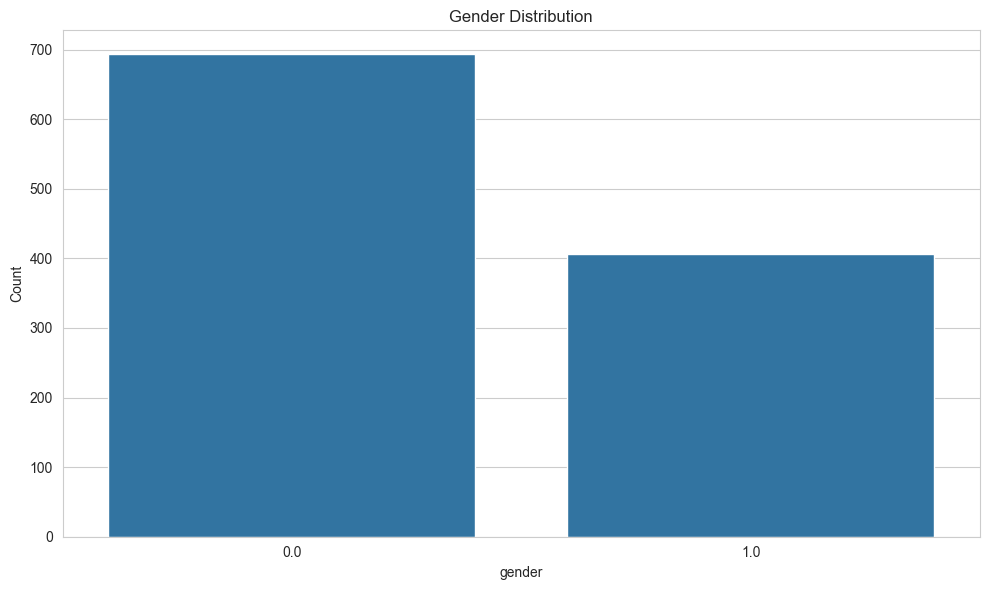

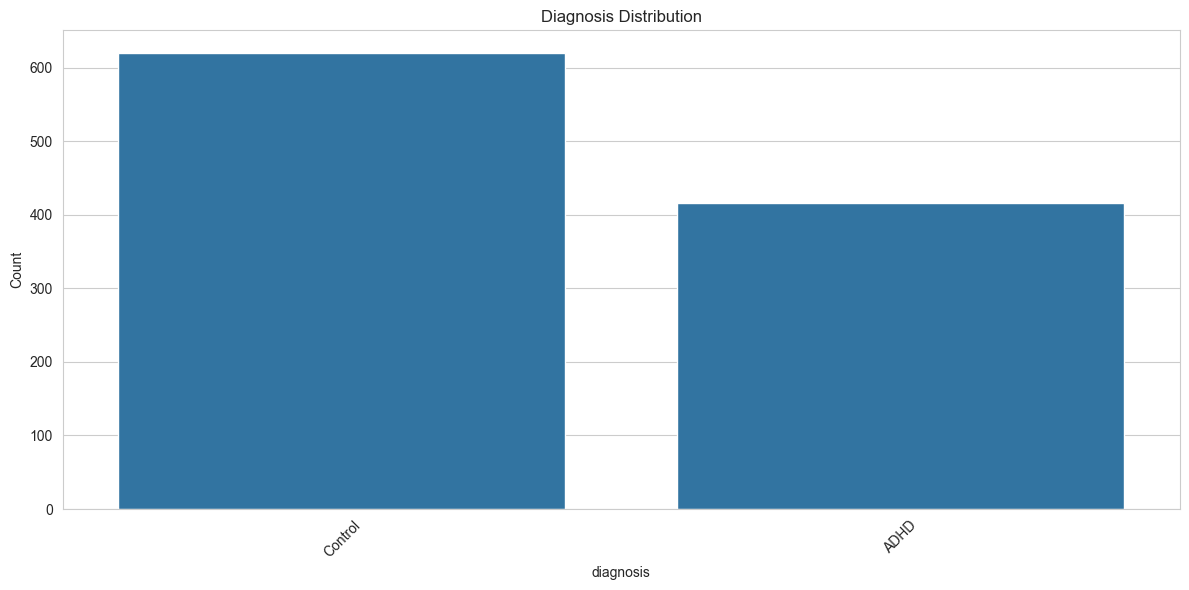

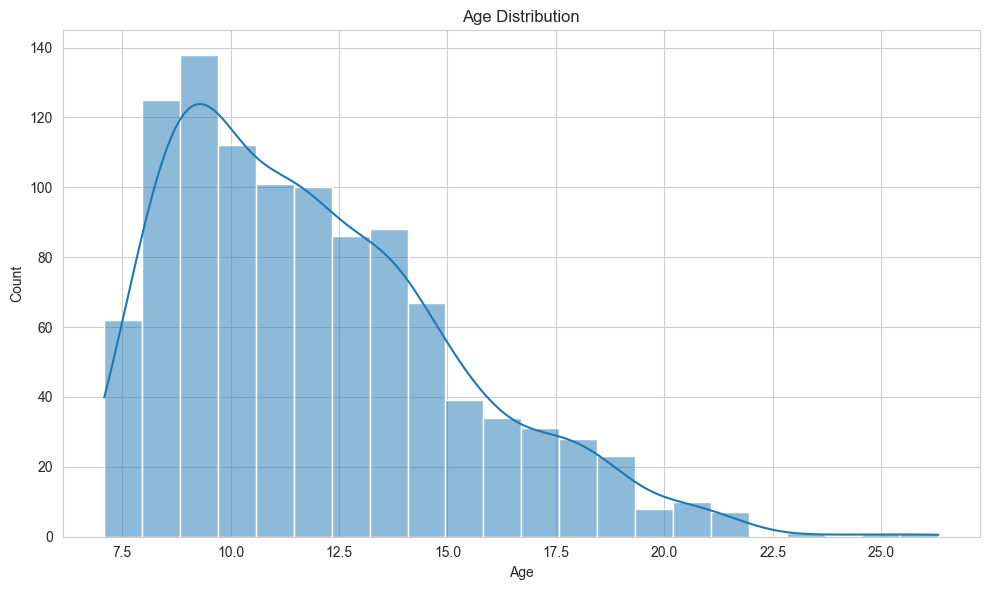

<Figure size 1200x600 with 0 Axes>

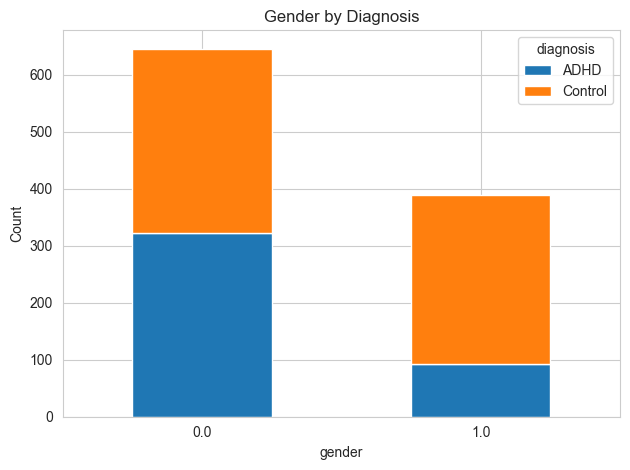

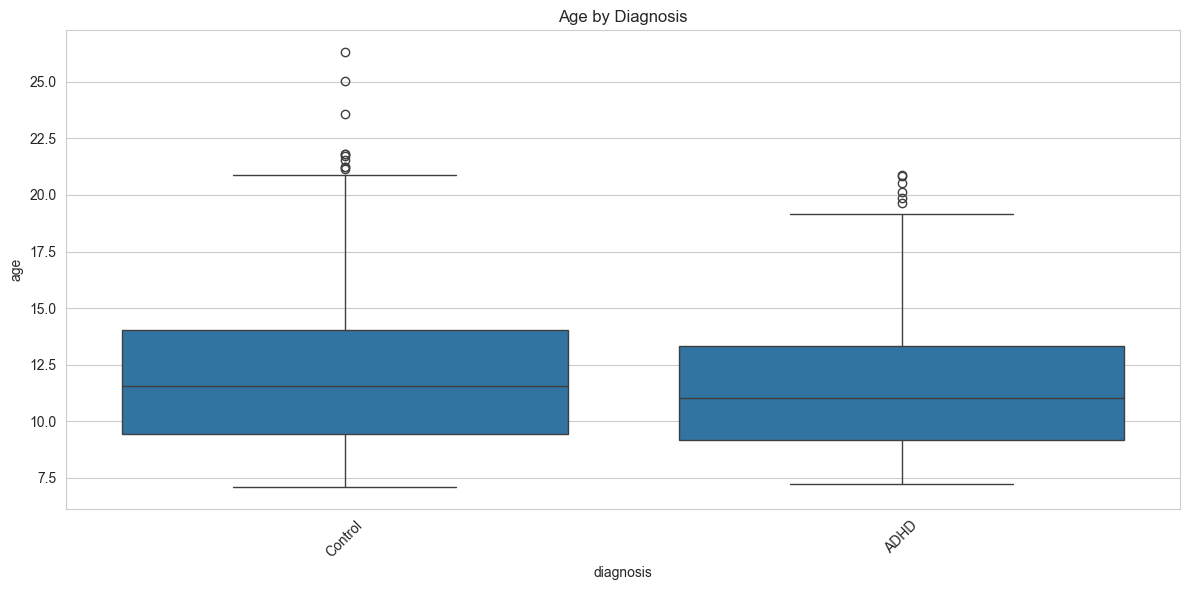

In [14]:
generate_visualizations(demographic_data)

In [15]:
demographic_data.to_csv('processed_data/demographic_data.csv')

# Extracted Features

Using [FreeSurfer](https://surfer.nmr.mgh.harvard.edu), we performed comprehensive segmentation of T1-weighted MRI scans to extract neuroanatomical features for our classification model. FreeSurfer's automated pipeline provided detailed morphometric measurements, including cortical thickness, surface area, and subcortical volumetric data across multiple brain regions.

These extracted features were particularly valuable as they captured subtle structural differences that may not be apparent in visual inspection alone. For each participant, we obtained regional measurements from both hemisphere's cortical parcellations (based on the Desikan-Killiany atlas) and subcortical segmentations, yielding over 100 distinct neuroanatomical variables.

In [16]:
def read_feature_file(file_path, sep='\t', index_col=None):
    """Read a tab-delimited file into a pandas DataFrame."""
    try:
        df = pd.read_csv(file_path, sep=sep, index_col=index_col)
        print(f"Successfully read {file_path}, containing {df.shape[0]} subjects and {df.shape[1]} variables.")
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file_path}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"Error: File '{file_path}' could not be parsed as a tab-delimited file.")
        return None
    except Exception as e:
        print(f"Unexpected error reading '{file_path}': {str(e)}")
        return None

In [17]:
def combine_dataframes(dataframes, file_names):
    """Combine multiple dataframes, handling duplicate columns."""
    if not dataframes:
        return None

    # Start with the first dataframe
    combined_df = dataframes[0].copy()
    print(f"Starting with {file_names[0]}: {combined_df.shape[1]} columns")

    # Add each additional dataframe
    for i in range(1, len(dataframes)):
        df = dataframes[i]

        # Identify duplicate columns
        duplicate_columns = list(set(combined_df.columns) & set(df.columns))
        if duplicate_columns:
            print(f"Found {len(duplicate_columns)} duplicate columns when adding {file_names[i]}: {duplicate_columns}")

            # Check if the duplicate columns have the same values
            for col in duplicate_columns:
                common_indices = combined_df.index.intersection(df.index)
                if not combined_df.loc[common_indices, col].equals(df.loc[common_indices, col]):
                    print(f"Warning: Column '{col}' has different values in {file_names[0]} and {file_names[i]}!")

            # Remove duplicate columns from the new dataframe
            df = df.drop(columns=duplicate_columns)

        # Combine the dataframes
        combined_df = pd.concat([combined_df, df], axis=1)
        print(f"After adding {file_names[i]}: {combined_df.shape[1]} columns")

    return combined_df

In [18]:
dataframes = []
feature_data_dict = {
    'aseg_volumes': 'raw_data/extracted_feature/aseg_volumes.txt',
    'lh_area': 'raw_data/extracted_feature/lh_area.txt',
    'lh_thickness': 'raw_data/extracted_feature/lh_thickness.txt',
    'lh_volume': 'raw_data/extracted_feature/lh_volume.txt',
    'rh_area': 'raw_data/extracted_feature/rh_area.txt',
    'rh_thickness': 'raw_data/extracted_feature/rh_thickness.txt',
    'rh_volume': 'raw_data/extracted_feature/rh_volume.txt',
}

for feature_type, file_path in feature_data_dict.items():
    feature_data = read_feature_file(file_path, sep='\t', index_col=0)
    if feature_data is None:
        print(f"Exiting due to error reading {file_path}")
        sys.exit(1)
    dataframes.append(feature_data)

Successfully read raw_data/extracted_feature/aseg_volumes.txt, containing 203 subjects and 65 variables.
Successfully read raw_data/extracted_feature/lh_area.txt, containing 203 subjects and 38 variables.
Successfully read raw_data/extracted_feature/lh_thickness.txt, containing 203 subjects and 38 variables.
Successfully read raw_data/extracted_feature/lh_volume.txt, containing 203 subjects and 37 variables.
Successfully read raw_data/extracted_feature/rh_area.txt, containing 203 subjects and 38 variables.
Successfully read raw_data/extracted_feature/rh_thickness.txt, containing 203 subjects and 38 variables.
Successfully read raw_data/extracted_feature/rh_volume.txt, containing 203 subjects and 37 variables.


In [19]:
combined_feature_data = combine_dataframes(dataframes, list(feature_data_dict.keys()))

Starting with aseg_volumes: 65 columns
Found 1 duplicate columns when adding lh_area: ['BrainSegVolNotVent']
After adding lh_area: 102 columns
Found 2 duplicate columns when adding lh_thickness: ['eTIV', 'BrainSegVolNotVent']
After adding lh_thickness: 138 columns
Found 2 duplicate columns when adding lh_volume: ['eTIV', 'BrainSegVolNotVent']
After adding lh_volume: 173 columns
Found 2 duplicate columns when adding rh_area: ['eTIV', 'BrainSegVolNotVent']
After adding rh_area: 209 columns
Found 2 duplicate columns when adding rh_thickness: ['eTIV', 'BrainSegVolNotVent']
After adding rh_thickness: 245 columns
Found 2 duplicate columns when adding rh_volume: ['eTIV', 'BrainSegVolNotVent']
After adding rh_volume: 280 columns


In [20]:
combined_feature_data.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume
subject_id,,,,,,,,,,,,,,,,,,,,,
sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,1305.9,...,18757.0,24884.0,14151.0,12134.0,11197.0,1626.0,2100.0,875.0,5565.0,992979.0
sub-6568351,5304.9,418.0,12851.3,60354.1,6557.8,3832.1,5498.3,1498.4,763.9,2403.8,...,19605.0,29632.0,13509.0,11390.0,11809.0,2032.0,1890.0,1030.0,5512.0,1062350.0
sub-0010029,9169.5,632.3,13238.4,55460.8,6471.6,4523.3,6335.9,1977.4,1161.6,3188.5,...,21277.0,25251.0,14433.0,13951.0,11704.0,1919.0,1871.0,1277.0,5830.0,1126028.0
sub-0010027,5143.7,632.3,11137.3,47115.4,6769.7,4062.3,5733.6,1574.8,524.0,1158.3,...,18397.0,28134.0,14696.0,14134.0,12703.0,1407.0,1873.0,1251.0,6944.0,1061340.0
sub-7333005,4499.2,681.2,15137.2,63323.7,8509.2,4692.6,6204.7,2005.6,931.3,1852.5,...,15784.0,28117.0,18107.0,15735.0,12888.0,1465.0,2506.0,1233.0,8837.0,1221867.0


In [21]:
# Or for a summary of the data
print(combined_feature_data.describe())

       Left-Lateral-Ventricle  Left-Inf-Lat-Vent  \
count              203.000000         203.000000   
mean              6569.547291         576.220690   
std               3456.398883         167.128507   
min               2561.500000          10.700000   
25%               4544.500000         454.650000   
50%               5667.400000         541.500000   
75%               7433.650000         669.900000   
max              27775.000000        1165.400000   

       Left-Cerebellum-White-Matter  Left-Cerebellum-Cortex  Left-Thalamus  \
count                    203.000000              203.000000     203.000000   
mean                   13869.769951            58838.054187    7565.408374   
std                     2372.389546             8539.736369     858.105587   
min                        0.000000              105.500000    4907.900000   
25%                    12626.050000            54534.600000    6967.650000   
50%                    13588.600000            59080.400000    

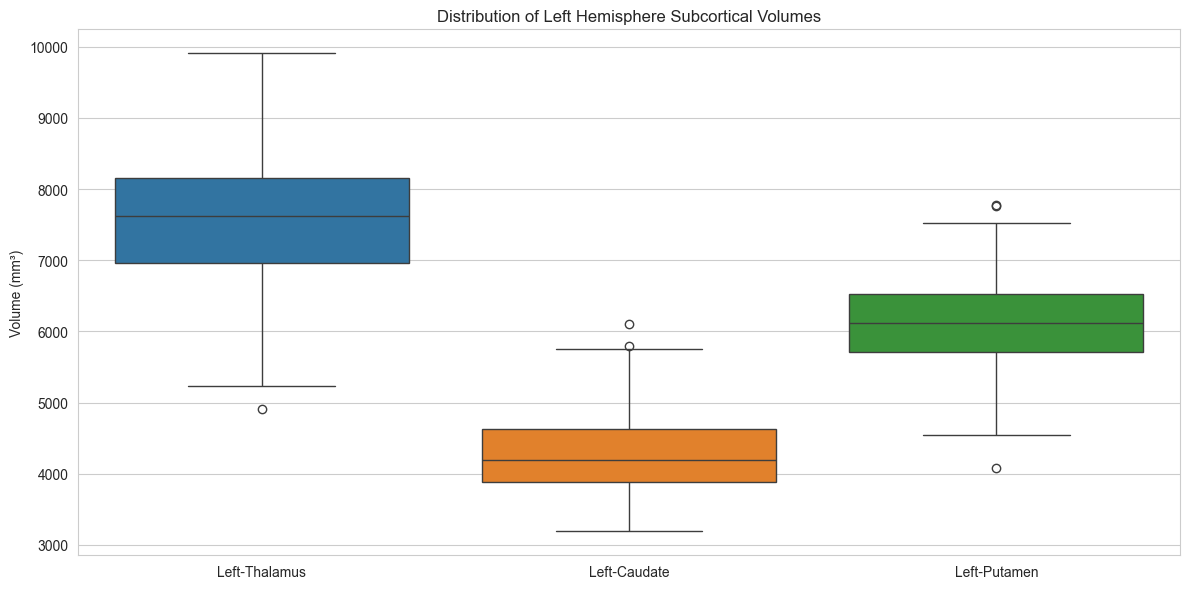

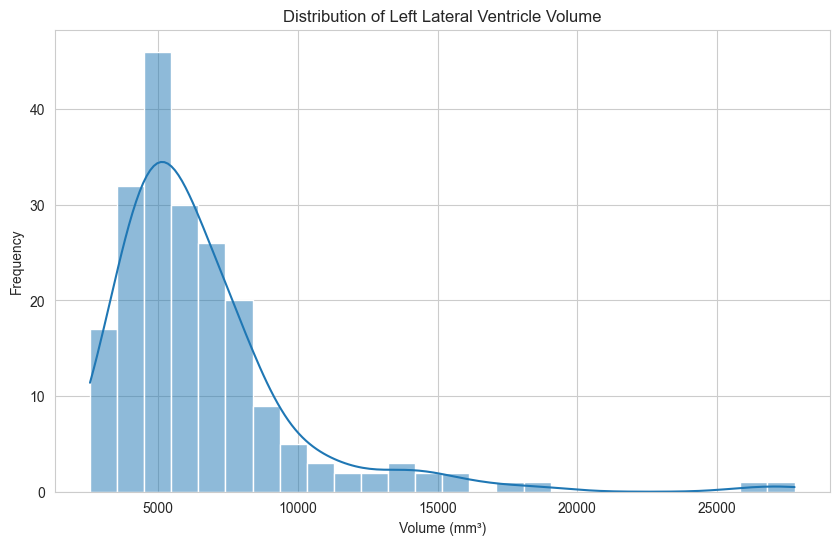

In [22]:
# Boxplot for a set of features
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_feature_data[['Left-Thalamus', 'Left-Caudate', 'Left-Putamen']])
plt.title('Distribution of Left Hemisphere Subcortical Volumes')
plt.ylabel('Volume (mm³)')
plt.tight_layout()
plt.show()

# Histogram for a specific feature
plt.figure(figsize=(10, 6))
sns.histplot(combined_feature_data['Left-Lateral-Ventricle'], kde=True)
plt.title('Distribution of Left Lateral Ventricle Volume')
plt.xlabel('Volume (mm³)')
plt.ylabel('Frequency')
plt.show()

In [23]:
combined_feature_data.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume
subject_id,,,,,,,,,,,,,,,,,,,,,
sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,1305.9,...,18757.0,24884.0,14151.0,12134.0,11197.0,1626.0,2100.0,875.0,5565.0,992979.0
sub-6568351,5304.9,418.0,12851.3,60354.1,6557.8,3832.1,5498.3,1498.4,763.9,2403.8,...,19605.0,29632.0,13509.0,11390.0,11809.0,2032.0,1890.0,1030.0,5512.0,1062350.0
sub-0010029,9169.5,632.3,13238.4,55460.8,6471.6,4523.3,6335.9,1977.4,1161.6,3188.5,...,21277.0,25251.0,14433.0,13951.0,11704.0,1919.0,1871.0,1277.0,5830.0,1126028.0
sub-0010027,5143.7,632.3,11137.3,47115.4,6769.7,4062.3,5733.6,1574.8,524.0,1158.3,...,18397.0,28134.0,14696.0,14134.0,12703.0,1407.0,1873.0,1251.0,6944.0,1061340.0
sub-7333005,4499.2,681.2,15137.2,63323.7,8509.2,4692.6,6204.7,2005.6,931.3,1852.5,...,15784.0,28117.0,18107.0,15735.0,12888.0,1465.0,2506.0,1233.0,8837.0,1221867.0


In [24]:
demographic_data.head()

,subject_id,gender,age,diagnosis,adhd_binary
0,sub-0026001,0.0,16.92,NaN,NaN
1,sub-0026002,0.0,15.68,NaN,NaN
2,sub-0026004,1.0,14.99,NaN,NaN
3,sub-0026005,1.0,15.16,NaN,NaN
4,sub-0026009,0.0,16.91,NaN,NaN


In [25]:
# Reset index to use subject_id as the index
demographic_data = demographic_data.set_index('subject_id')
demographic_data.head()

,gender,age,diagnosis,adhd_binary
subject_id,,,,
sub-0026001,0.0,16.92,NaN,NaN
sub-0026002,0.0,15.68,NaN,NaN
sub-0026004,1.0,14.99,NaN,NaN
sub-0026005,1.0,15.16,NaN,NaN
sub-0026009,0.0,16.91,NaN,NaN


In [26]:
merged_data = pd.merge(
    combined_feature_data,
    demographic_data,
    left_index=True,
    right_index=True,
    how='inner'  # Only keep rows that exist in both DataFrames
)
merged_data.reset_index(inplace=True)
merged_data.head()

,subject_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary
0,sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,...,11197.0,1626.0,2100.0,875.0,5565.0,992979.0,1.0,9.16,ADHD,NaN
1,sub-6568351,5304.9,418.0,12851.3,60354.1,6557.8,3832.1,5498.3,1498.4,763.9,...,11809.0,2032.0,1890.0,1030.0,5512.0,1062350.0,1.0,8.10,Control,NaN
2,sub-0010029,9169.5,632.3,13238.4,55460.8,6471.6,4523.3,6335.9,1977.4,1161.6,...,11704.0,1919.0,1871.0,1277.0,5830.0,1126028.0,1.0,13.09,ADHD,NaN
3,sub-0010027,5143.7,632.3,11137.3,47115.4,6769.7,4062.3,5733.6,1574.8,524.0,...,12703.0,1407.0,1873.0,1251.0,6944.0,1061340.0,0.0,8.28,ADHD,NaN
4,sub-7333005,4499.2,681.2,15137.2,63323.7,8509.2,4692.6,6204.7,2005.6,931.3,...,12888.0,1465.0,2506.0,1233.0,8837.0,1221867.0,0.0,9.00,ADHD,NaN


In [27]:
generate_data_statistics(merged_data)

,Count,Percentage,Value
Total Subjects,224.0,NaN,NaN
Gender: 0.0,151.0,67.4%,NaN
Gender: 1.0,73.0,32.6%,NaN
Diagnosis: Control,116.0,51.8%,NaN
Diagnosis: ADHD,108.0,48.2%,NaN
Age: Mean,NaN,NaN,12.29
Age: Median,NaN,NaN,11.82
Age: Min,NaN,NaN,7.09
Age: Max,NaN,NaN,23.59
Age: StdDev,NaN,NaN,3.38


All visualizations have been saved to the 'plots' directory.


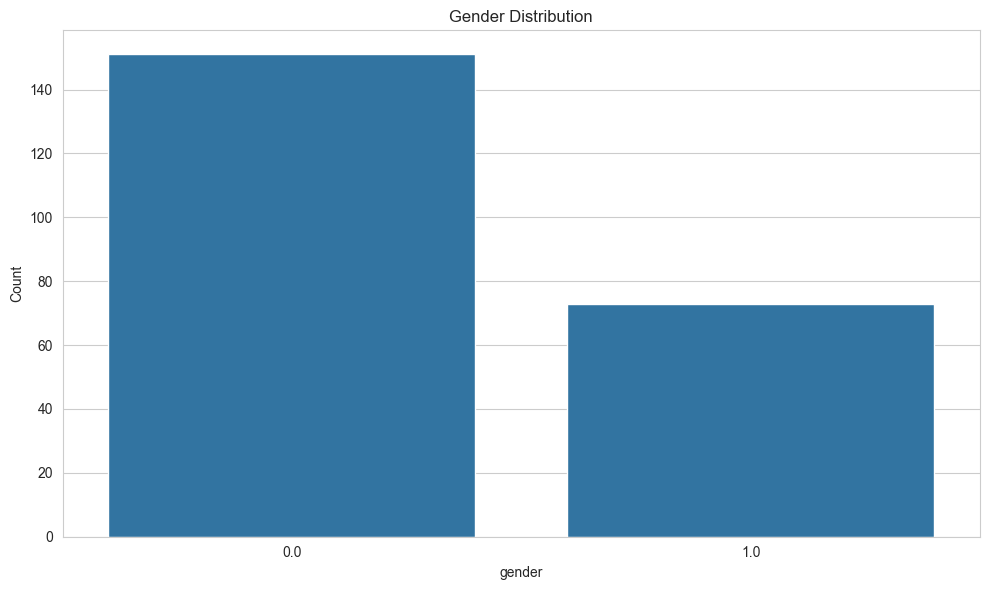

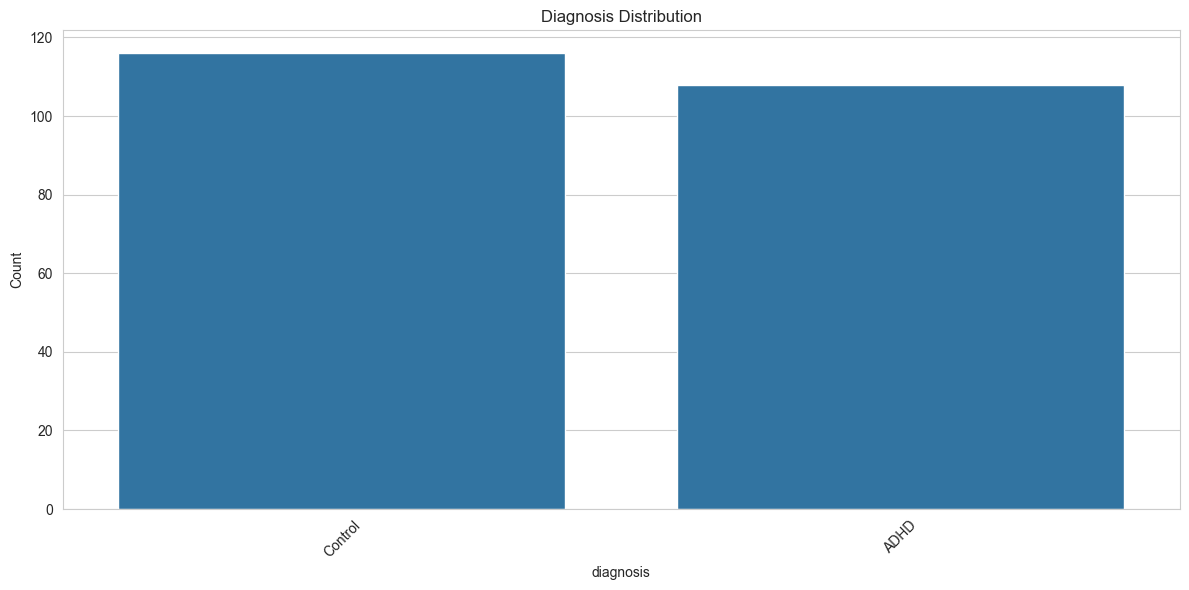

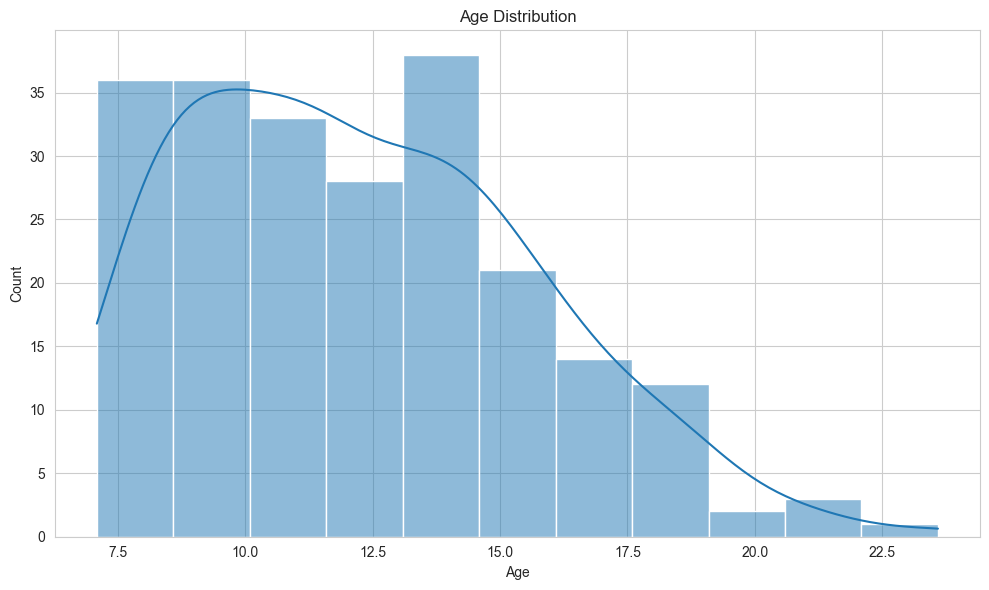

<Figure size 1200x600 with 0 Axes>

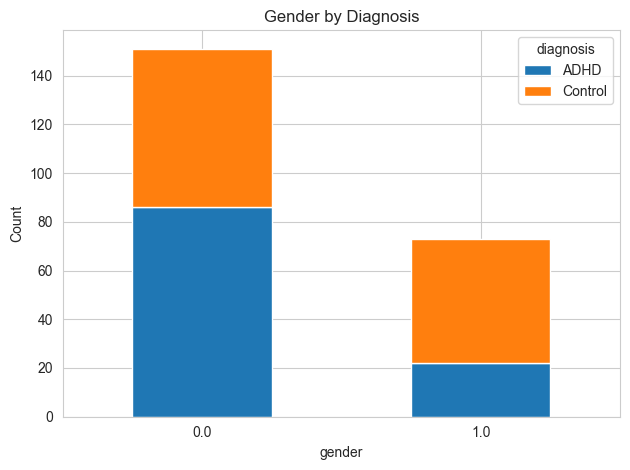

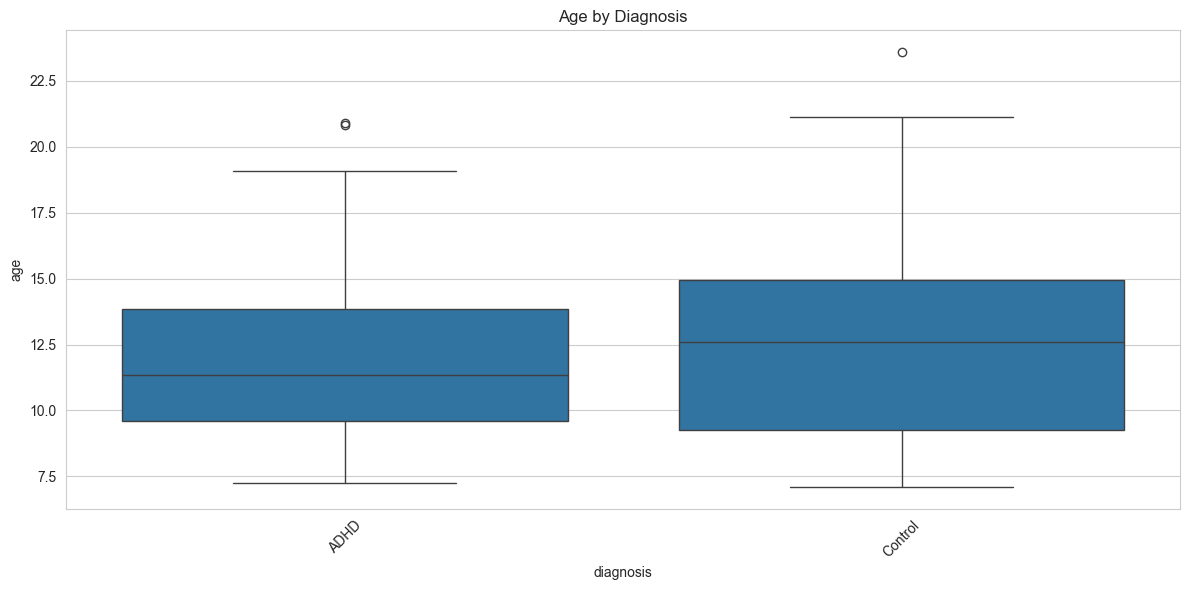

In [28]:
generate_visualizations(merged_data)

In [29]:
# Split the data into two groups
adhd = merged_data[merged_data['diagnosis'] == 'ADHD']
control = merged_data[merged_data['diagnosis'] == 'Control']

In [30]:
def cohensd(control, adhd):
    n1, n2 = len(control), len(adhd)
    s1, s2 = control.std(), adhd.std()
    pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (control.mean() - adhd.mean()) / pooled_std

def extract_stat_data(feature_name):
    adhd_values = adhd[feature_name]
    control_values = control[feature_name]

    # Check normality
    adhd_statistic, adhd_norm_p = stats.shapiro(adhd_values)
    control_statistic, control_norm_p = stats.shapiro(control_values)

    # Perform statistical test
    # If p > 0.05: data is normally distributed
    # If p < 0.05: data is not normally distributed
    print('stats.shapiro results:')
    print(f'\tADHD statistics: {adhd_statistic}. p-value: {adhd_norm_p}')
    print(f'\tControl statistics: {control_statistic}. p-value: {control_norm_p}')

    t_stat, t_test_p_value = stats.ttest_ind(adhd_values, control_values)
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {t_test_p_value:.4f}")

    u_stat, u_test_p_value = stats.mannwhitneyu(adhd_values, control_values)
    print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {u_test_p_value:.4f}")

    effect_size = cohensd(control_values, adhd_values)
    print(f"Cohen's d effect size: {effect_size:.4f}")

    # Create records for each group
    adhd_records = [{feature_name: val, 'group': 'ADHD'} for val in adhd_values]
    control_records = [{feature_name: val, 'group': 'Control'} for val in control_values]

    # Combine the values into a DataFrame
    data_dict = {
        feature_name: list(adhd_values) + list(control_values),
        'group': ['ADHD'] * len(adhd_values) + ['Control'] * len(control_values)
    }
    data = pd.DataFrame(data_dict)

    # Create a figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Row 1: Original histograms
    # Plot distribution for ADHD Group
    sns.histplot(adhd_values, ax=axes[0, 0], kde=True, color='steelblue')
    axes[0, 0].set_title(f'ADHD Distribution\nNormality p={adhd_norm_p:.4f}')
    axes[0, 0].set_xlabel(feature_name)
    axes[0, 0].set_ylabel('Count')

    # Plot distribution for Control Group
    sns.histplot(control_values, ax=axes[0, 1], kde=True, color='steelblue')
    axes[0, 1].set_title(f'Control Group Distribution\nNormality p={control_norm_p:.4f}')
    axes[0, 1].set_xlabel(feature_name)
    axes[0, 1].set_ylabel('Count')

    # Row 2: Box and violin plots
    # Create the data DataFrame if you don't have it yet
    # Boxplot
    sns.boxplot(x='group', y=feature_name, data=data, ax=axes[1, 0])
    axes[1, 0].set_title(f'{feature_name} by Group')
    axes[1, 0].set_xlabel('Group')
    axes[1, 0].set_ylabel(feature_name)

    # Violin plot
    sns.violinplot(x='group', y=feature_name, data=data, ax=axes[1, 1])
    axes[1, 1].set_title(f'Distribution of {feature_name} by Group')
    axes[1, 1].set_xlabel('Group')
    axes[1, 1].set_ylabel(feature_name)

    fig.suptitle(f'{feature_name} Analysis\nt-test: p={t_test_p_value:.4f}', fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the suptitle
    plt.show()


stats.shapiro results:
	ADHD statistics: 0.9779809244198684. p-value: 0.07010052443302138
	Control statistics: 0.9816257656221179. p-value: 0.11304362699462442
T-test: t-statistic = -0.1446, p-value = 0.8851
Mann-Whitney U test: U-statistic = 6250.0000, p-value = 0.9778
Cohen's d effect size: 0.0193


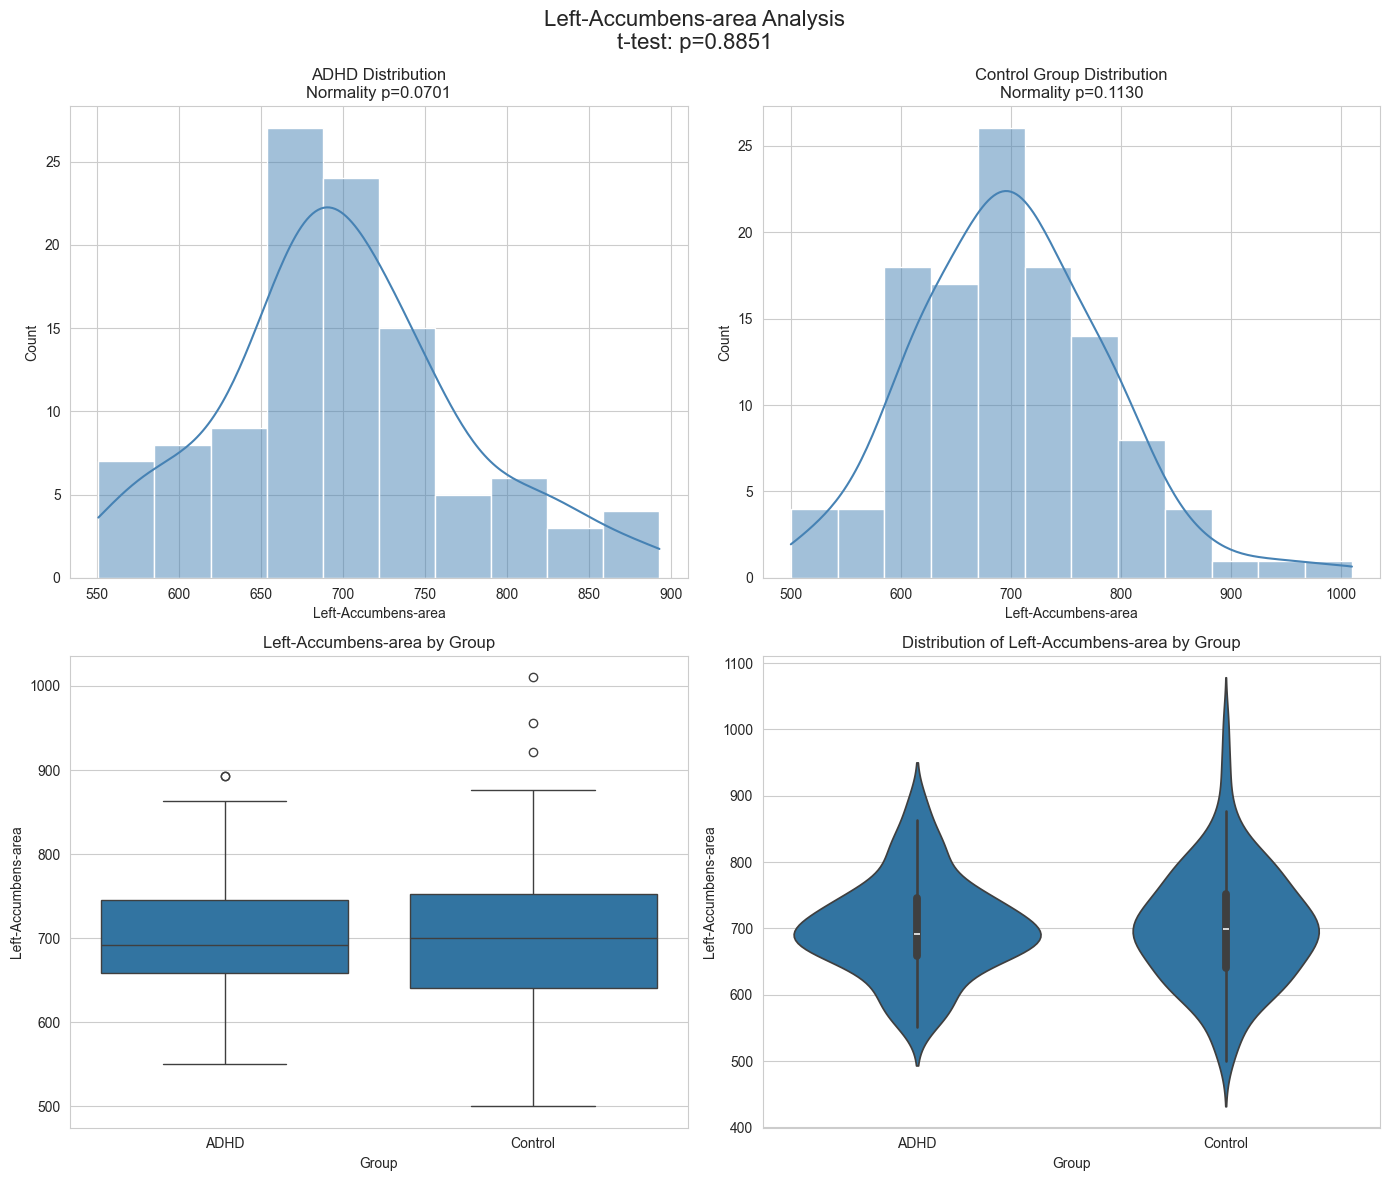

In [31]:
extract_stat_data('Left-Accumbens-area')

### Interpretation for Left-Accumbens-Area:

1. The high p-values (0.8851 and 0.9778) from both parametric and non-parametric tests indicate there is no statistically significant difference in left accumbens area between ADHD and control groups.
2. The statistical analysis and visualizations collectively suggest no statistically significant difference in the "Left-Accumbens-area" between ADHD and control groups, as indicated by the high p-values and the very small Cohen's d effect size. Both the distribution shapes and central tendencies are quite comparable, reinforcing the statistical findings.

stats.shapiro results:
	ADHD statistics: 0.9832735965055734. p-value: 0.1941783330342013
	Control statistics: 0.970896919968033. p-value: 0.012578766854781003
T-test: t-statistic = -0.2059, p-value = 0.8370
Mann-Whitney U test: U-statistic = 6324.5000, p-value = 0.9015
Cohen's d effect size: 0.0275


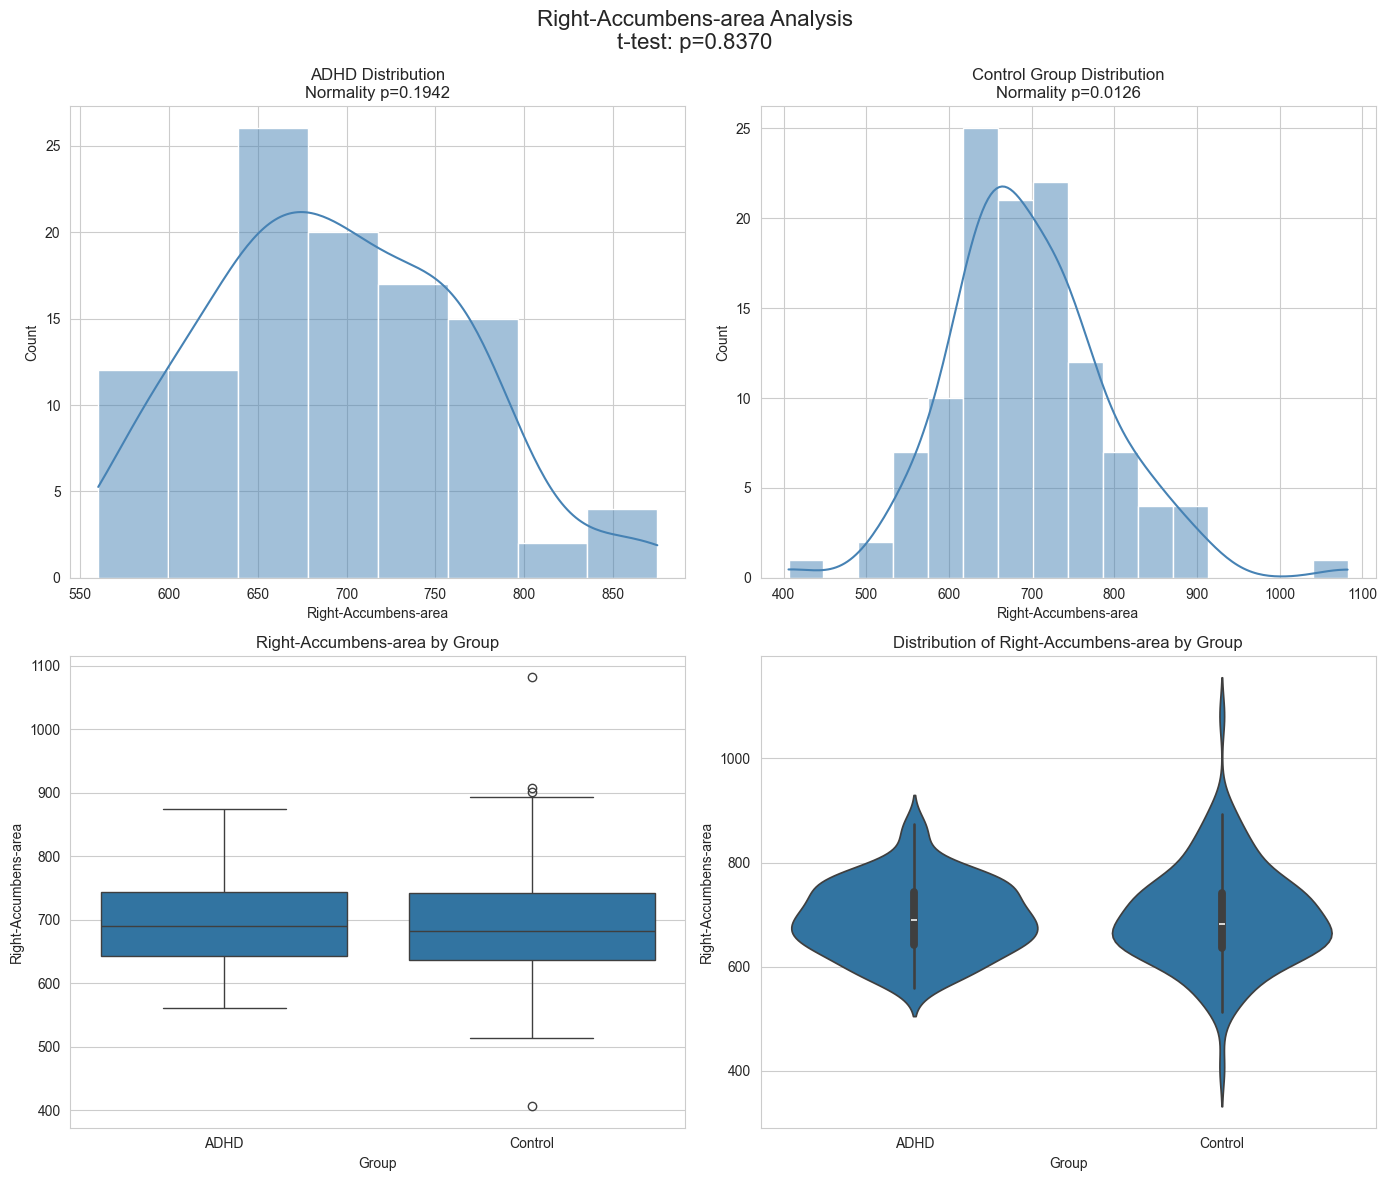

In [32]:
extract_stat_data('Right-Accumbens-area')

### Interpretation for Right-Accumbens-Area Analysis

1.  Similar to the left accumbens area, there is no statistically significant difference in right accumbens area between ADHD and control groups. Both statistical tests consistently show high p-values, and the effect size is extremely small, strongly suggesting no meaningful neuroanatomical difference in this brain region between the groups in this sample.

stats.shapiro results:
	ADHD statistics: 0.9799339165748119. p-value: 0.10237435996195521
	Control statistics: 0.9791371019994205. p-value: 0.06751403860483501
T-test: t-statistic = -1.0094, p-value = 0.3139
Mann-Whitney U test: U-statistic = 5555.5000, p-value = 0.1441
Cohen's d effect size: 0.1350


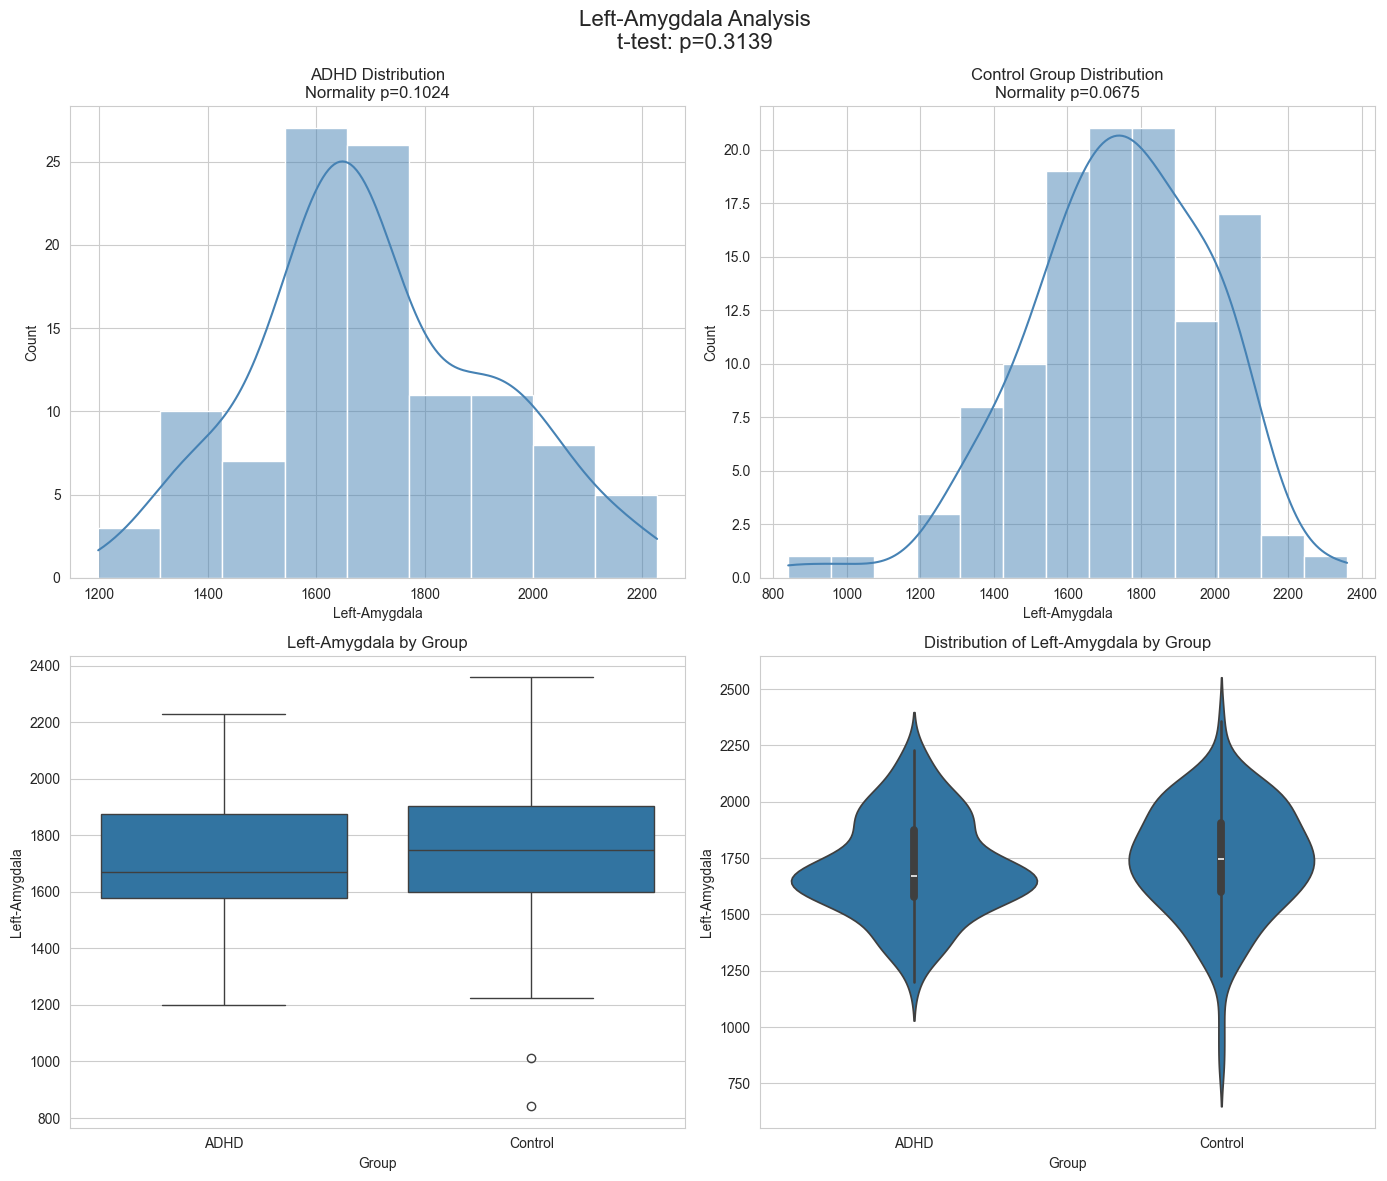

In [33]:
extract_stat_data('Left-Amygdala')

stats.shapiro results:
	ADHD statistics: 0.9895174582555203. p-value: 0.5707773102361017
	Control statistics: 0.9857864344575908. p-value: 0.2622850824620741
T-test: t-statistic = -1.6229, p-value = 0.1060
Mann-Whitney U test: U-statistic = 5323.5000, p-value = 0.0524
Cohen's d effect size: 0.2170


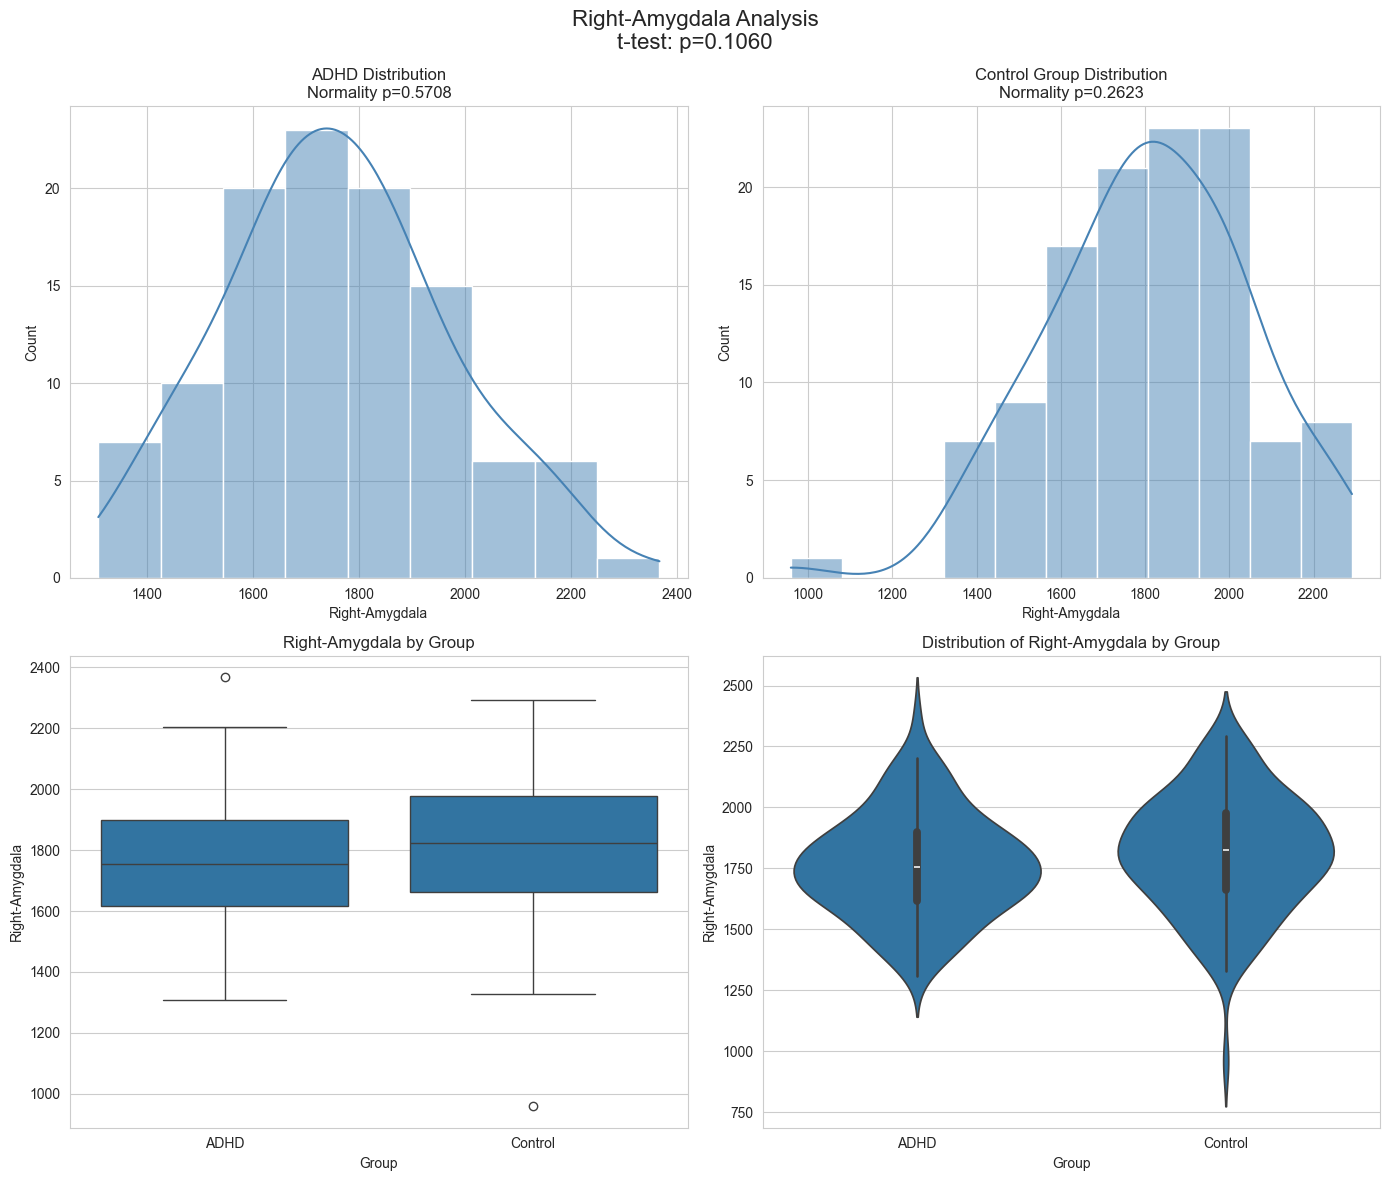

In [34]:
extract_stat_data('Right-Amygdala')

stats.shapiro results:
	ADHD statistics: 0.9632800150656629. p-value: 0.0044703080804363105
	Control statistics: 0.9763051242523408. p-value: 0.03760192747623064
T-test: t-statistic = -0.3025, p-value = 0.7626
Mann-Whitney U test: U-statistic = 6213.5000, p-value = 0.9178
Cohen's d effect size: 0.0404


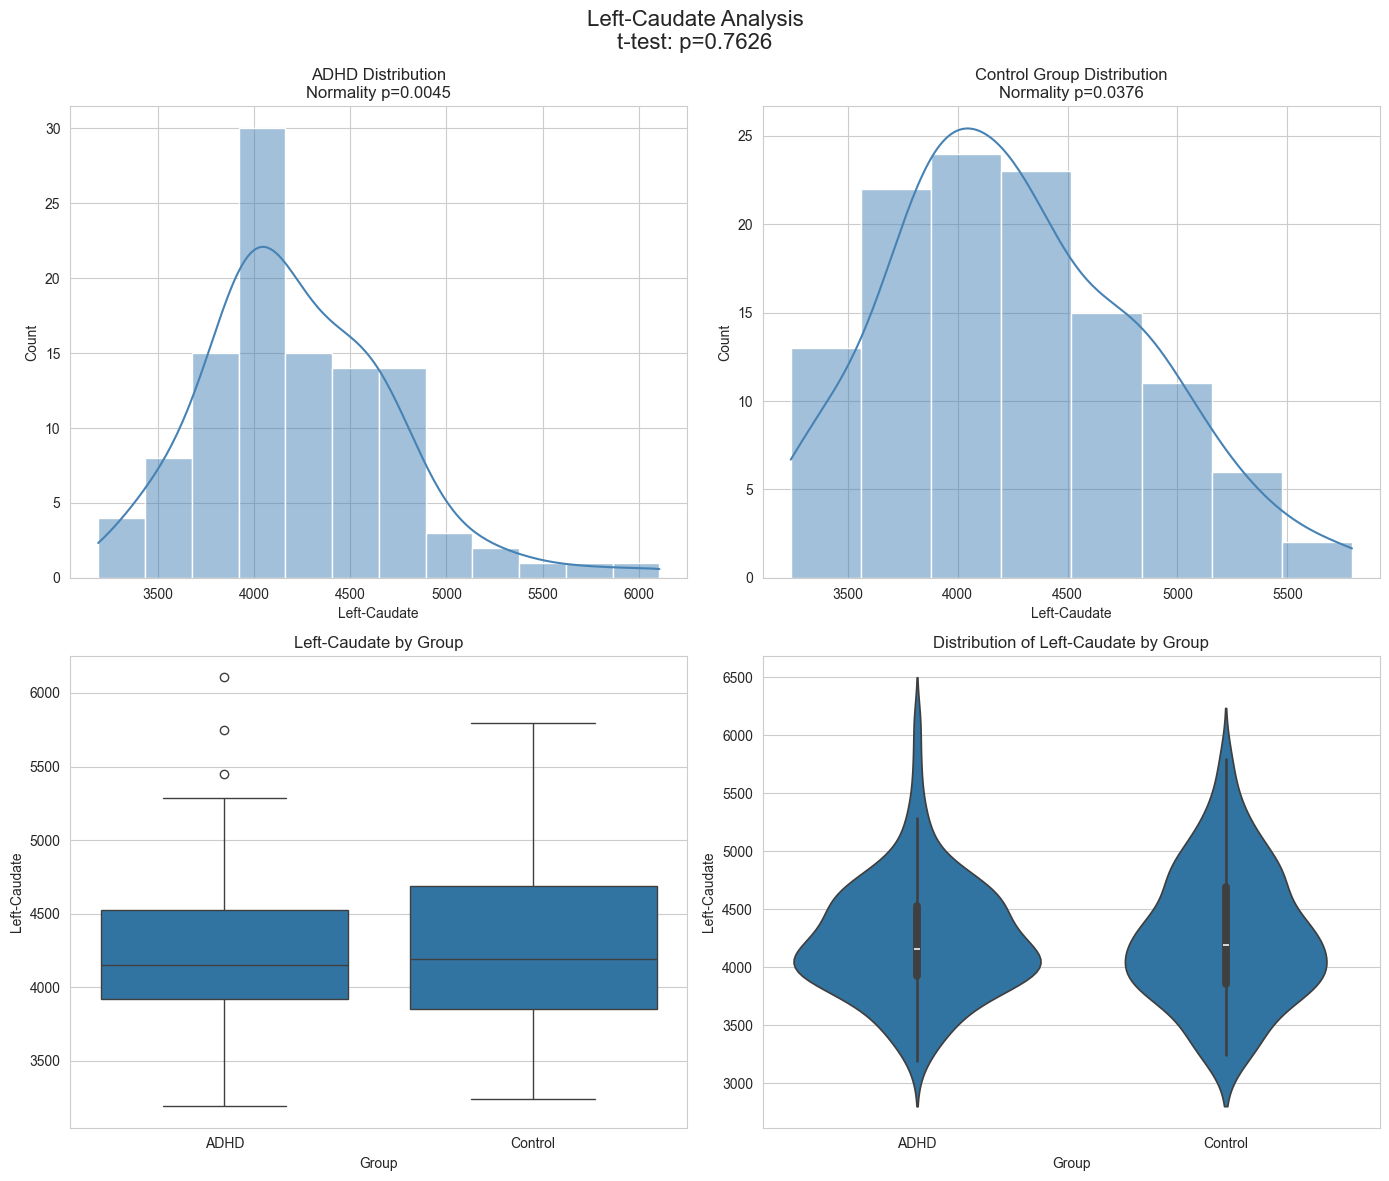

In [35]:
extract_stat_data('Left-Caudate')

stats.shapiro results:
	ADHD statistics: 0.9794764526277295. p-value: 0.09369250672366684
	Control statistics: 0.9768686432158092. p-value: 0.04222848482687606
T-test: t-statistic = -0.3664, p-value = 0.7144
Mann-Whitney U test: U-statistic = 6233.0000, p-value = 0.9498
Cohen's d effect size: 0.0490


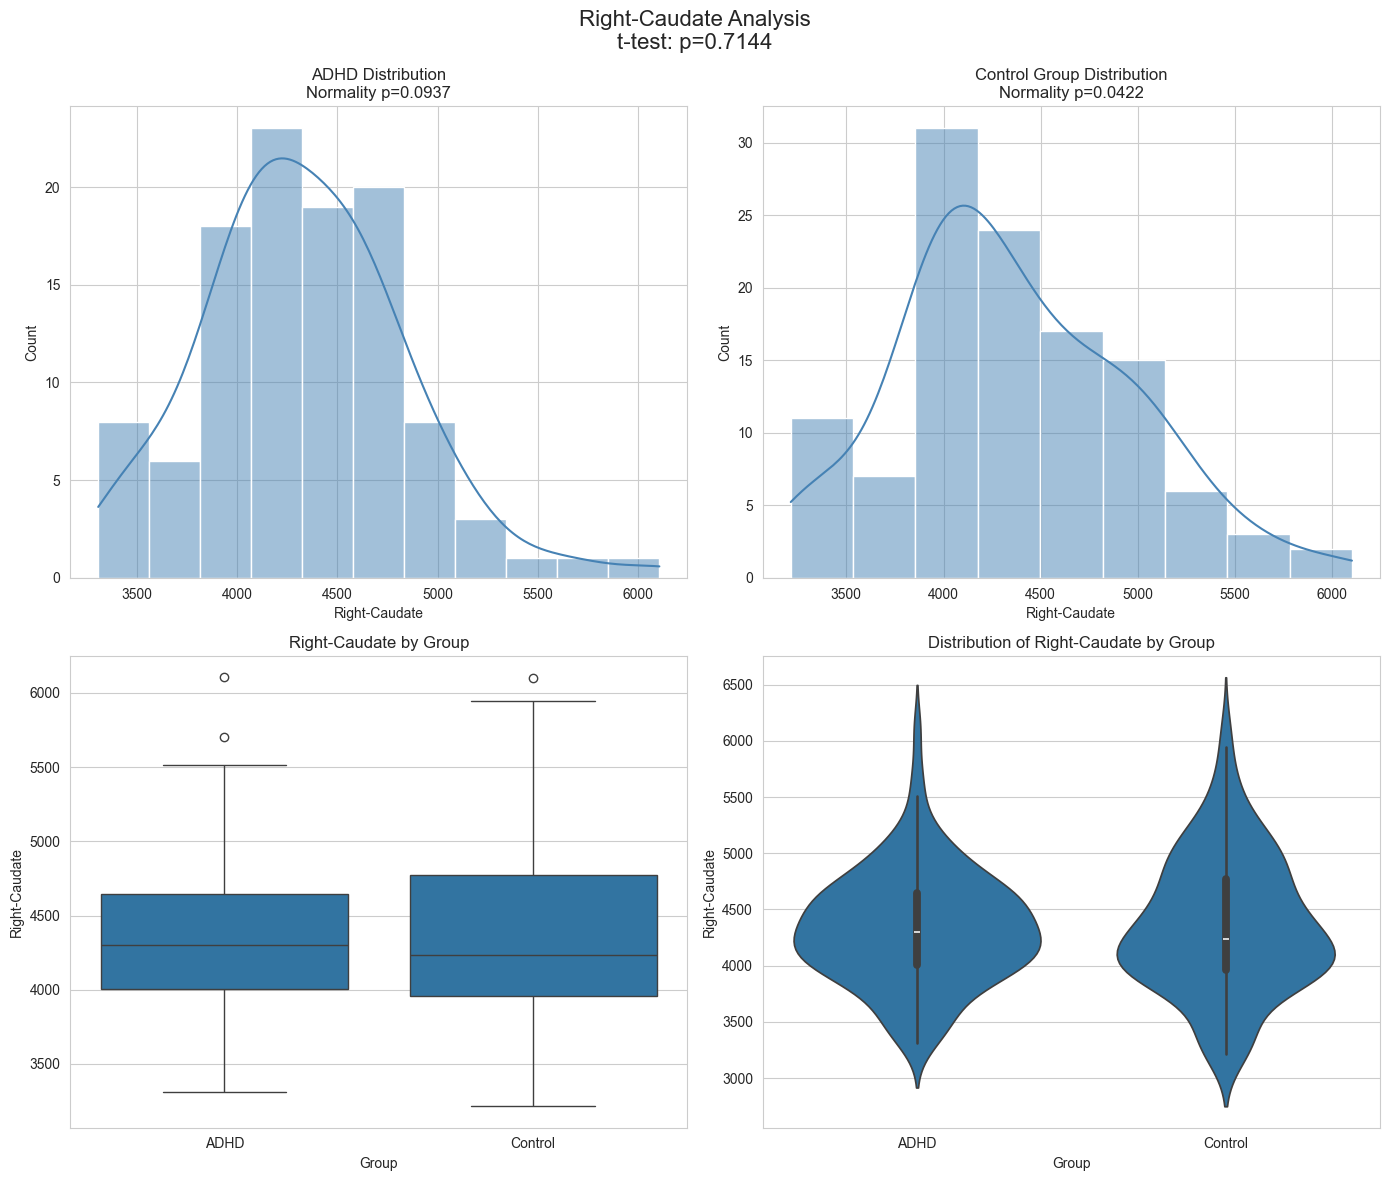

In [36]:
extract_stat_data('Right-Caudate')

stats.shapiro results:
	ADHD statistics: 0.9780323992677634. p-value: 0.07080405363216939
	Control statistics: 0.992071546342614. p-value: 0.7482890575213024
T-test: t-statistic = 0.2257, p-value = 0.8216
Mann-Whitney U test: U-statistic = 6227.0000, p-value = 0.9400
Cohen's d effect size: -0.0302


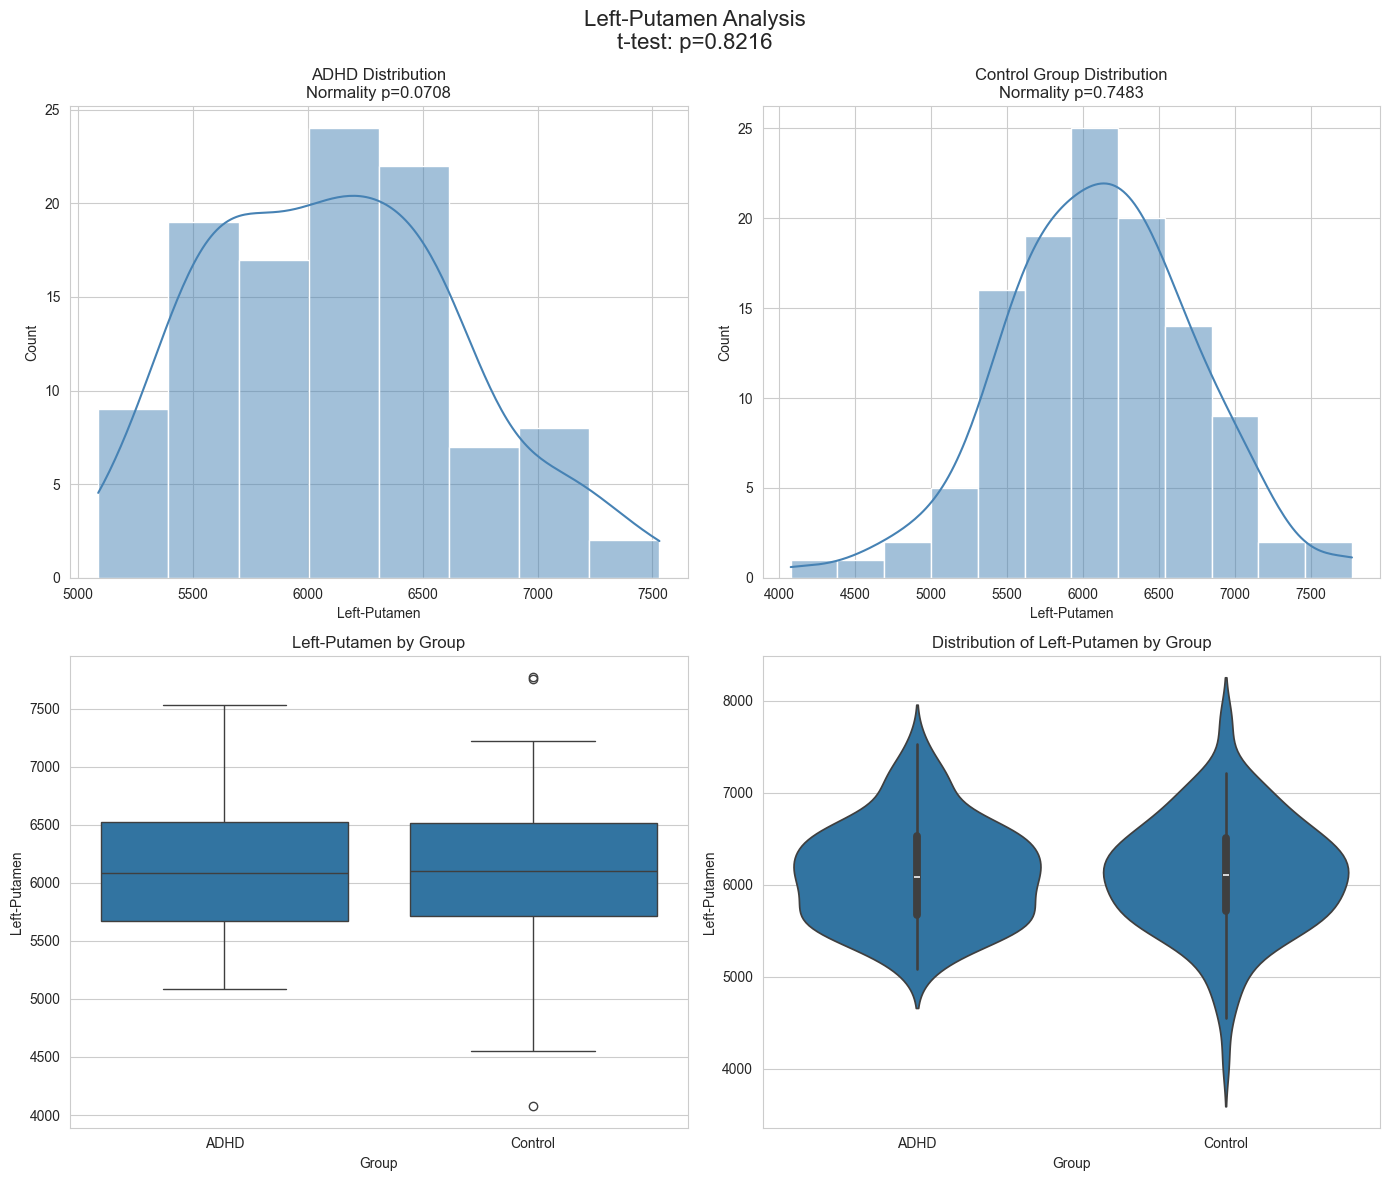

In [37]:
extract_stat_data('Left-Putamen')

stats.shapiro results:
	ADHD statistics: 0.977360377732952. p-value: 0.06215204265008841
	Control statistics: 0.9846105427754162. p-value: 0.20780157484532855
T-test: t-statistic = 0.6638, p-value = 0.5075
Mann-Whitney U test: U-statistic = 6477.0000, p-value = 0.6611
Cohen's d effect size: -0.0888


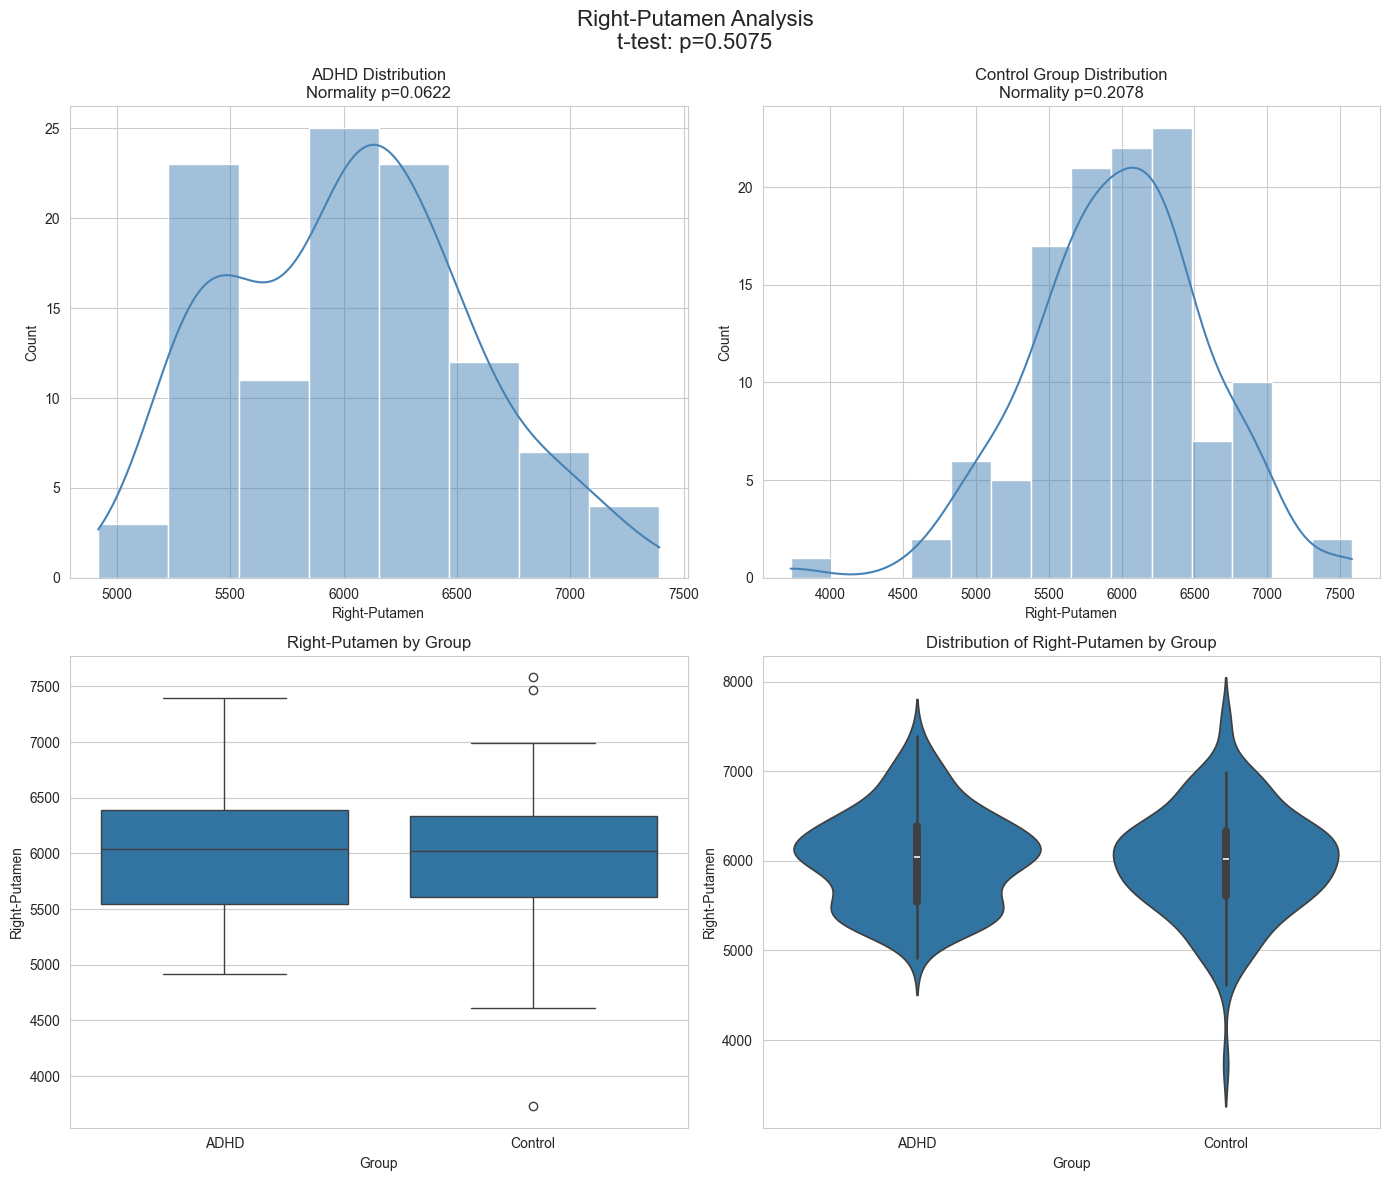

In [38]:
extract_stat_data('Right-Putamen')

stats.shapiro results:
	ADHD statistics: 0.8167200638297278. p-value: 2.8998658144602453e-10
	Control statistics: 0.9905076783997967. p-value: 0.6050805621292212
T-test: t-statistic = -1.2160, p-value = 0.2253
Mann-Whitney U test: U-statistic = 5836.0000, p-value = 0.3777
Cohen's d effect size: 0.1626


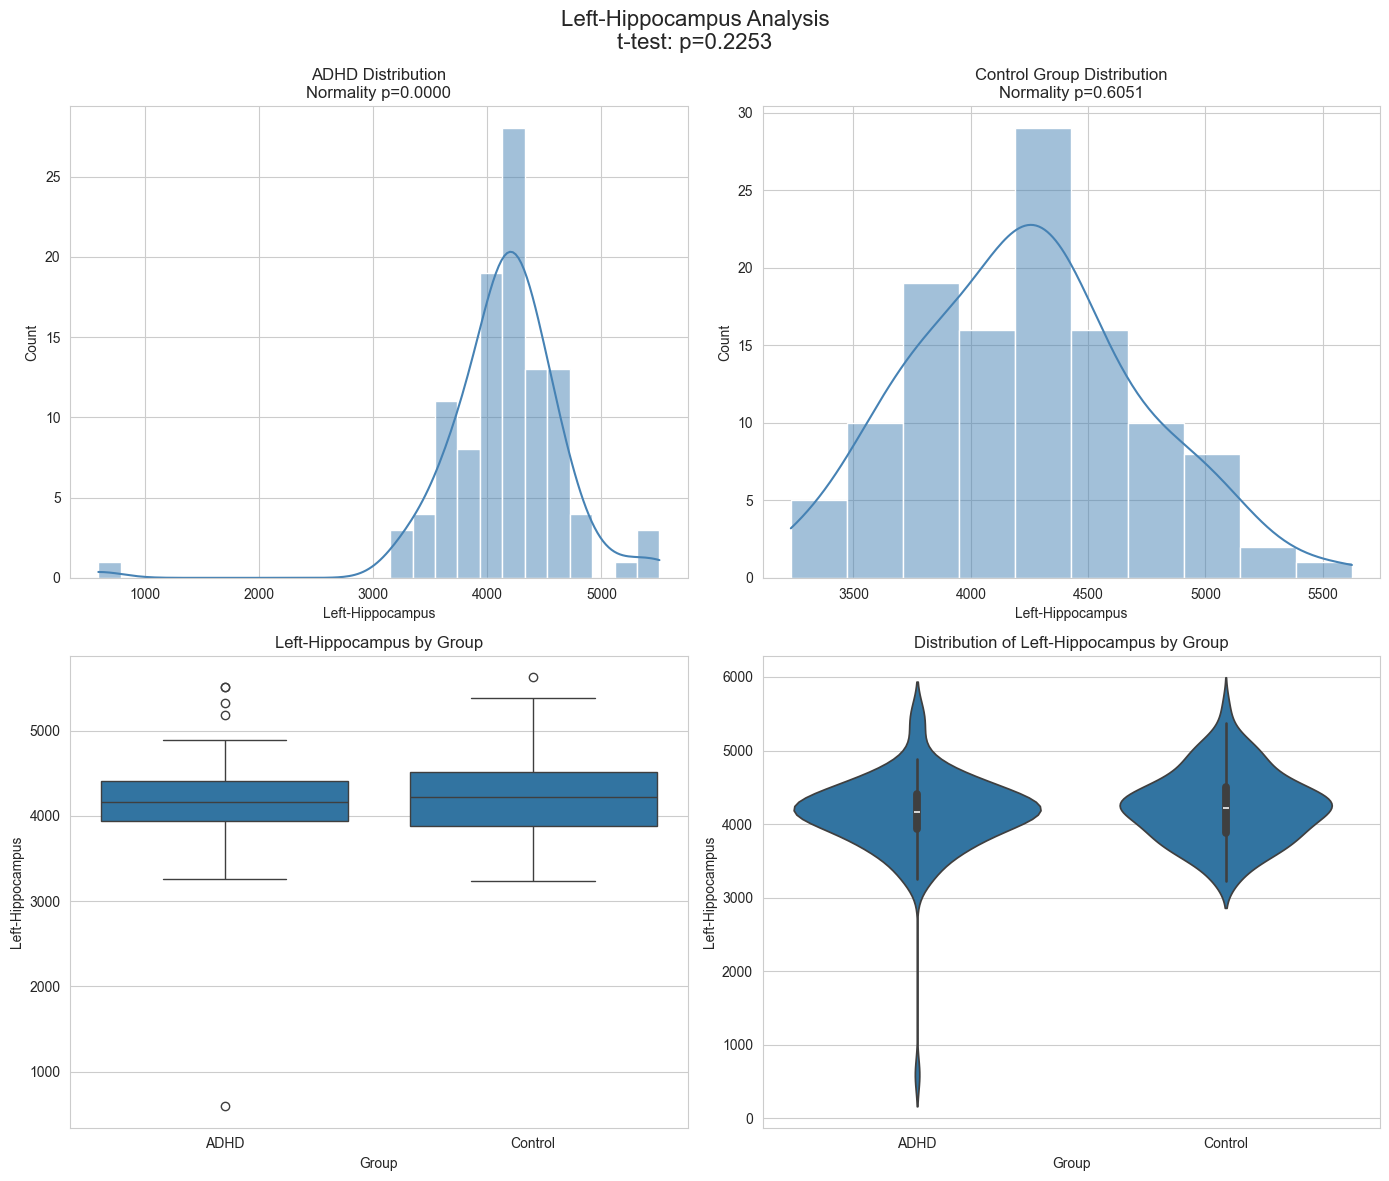

In [39]:
extract_stat_data('Left-Hippocampus')

stats.shapiro results:
	ADHD statistics: 0.9866424770306585. p-value: 0.35883611017501643
	Control statistics: 0.9889009461236097. p-value: 0.4668503354153341
T-test: t-statistic = -0.8656, p-value = 0.3877
Mann-Whitney U test: U-statistic = 5720.0000, p-value = 0.2621
Cohen's d effect size: 0.1157


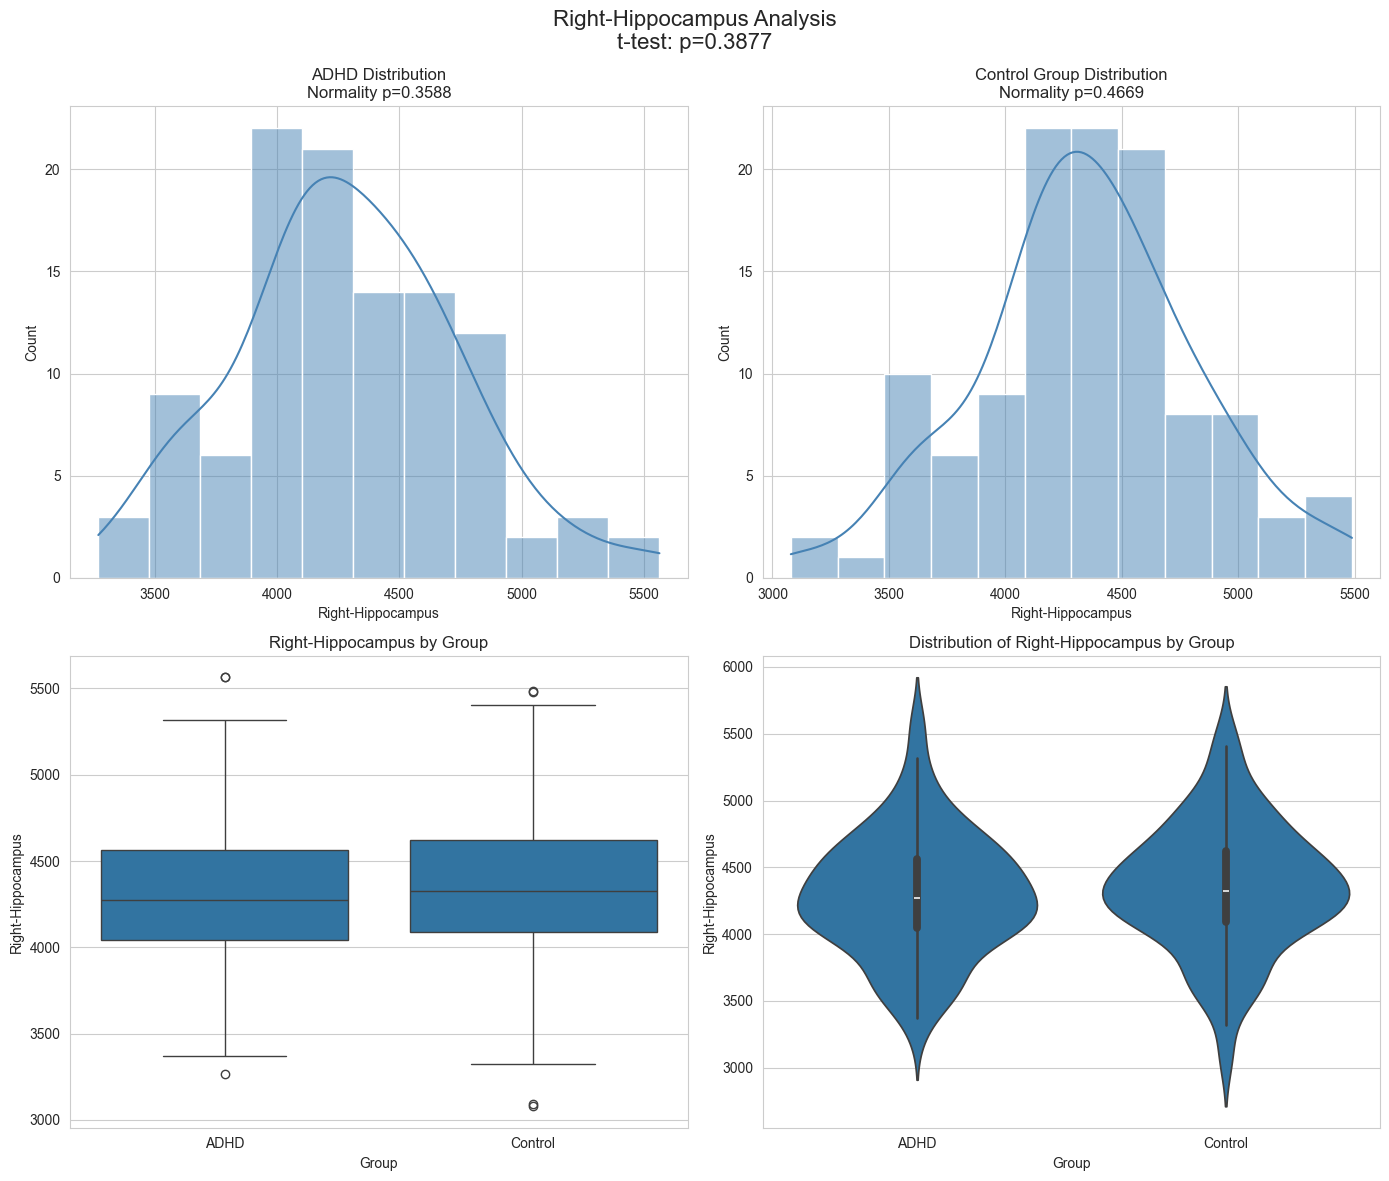

In [40]:
extract_stat_data('Right-Hippocampus')

stats.shapiro results:
	ADHD statistics: 0.8167200638297278. p-value: 2.8998658144602453e-10
	Control statistics: 0.9905076783997967. p-value: 0.6050805621292212
T-test: t-statistic = -1.2160, p-value = 0.2253
Mann-Whitney U test: U-statistic = 5836.0000, p-value = 0.3777
Cohen's d effect size: 0.1626


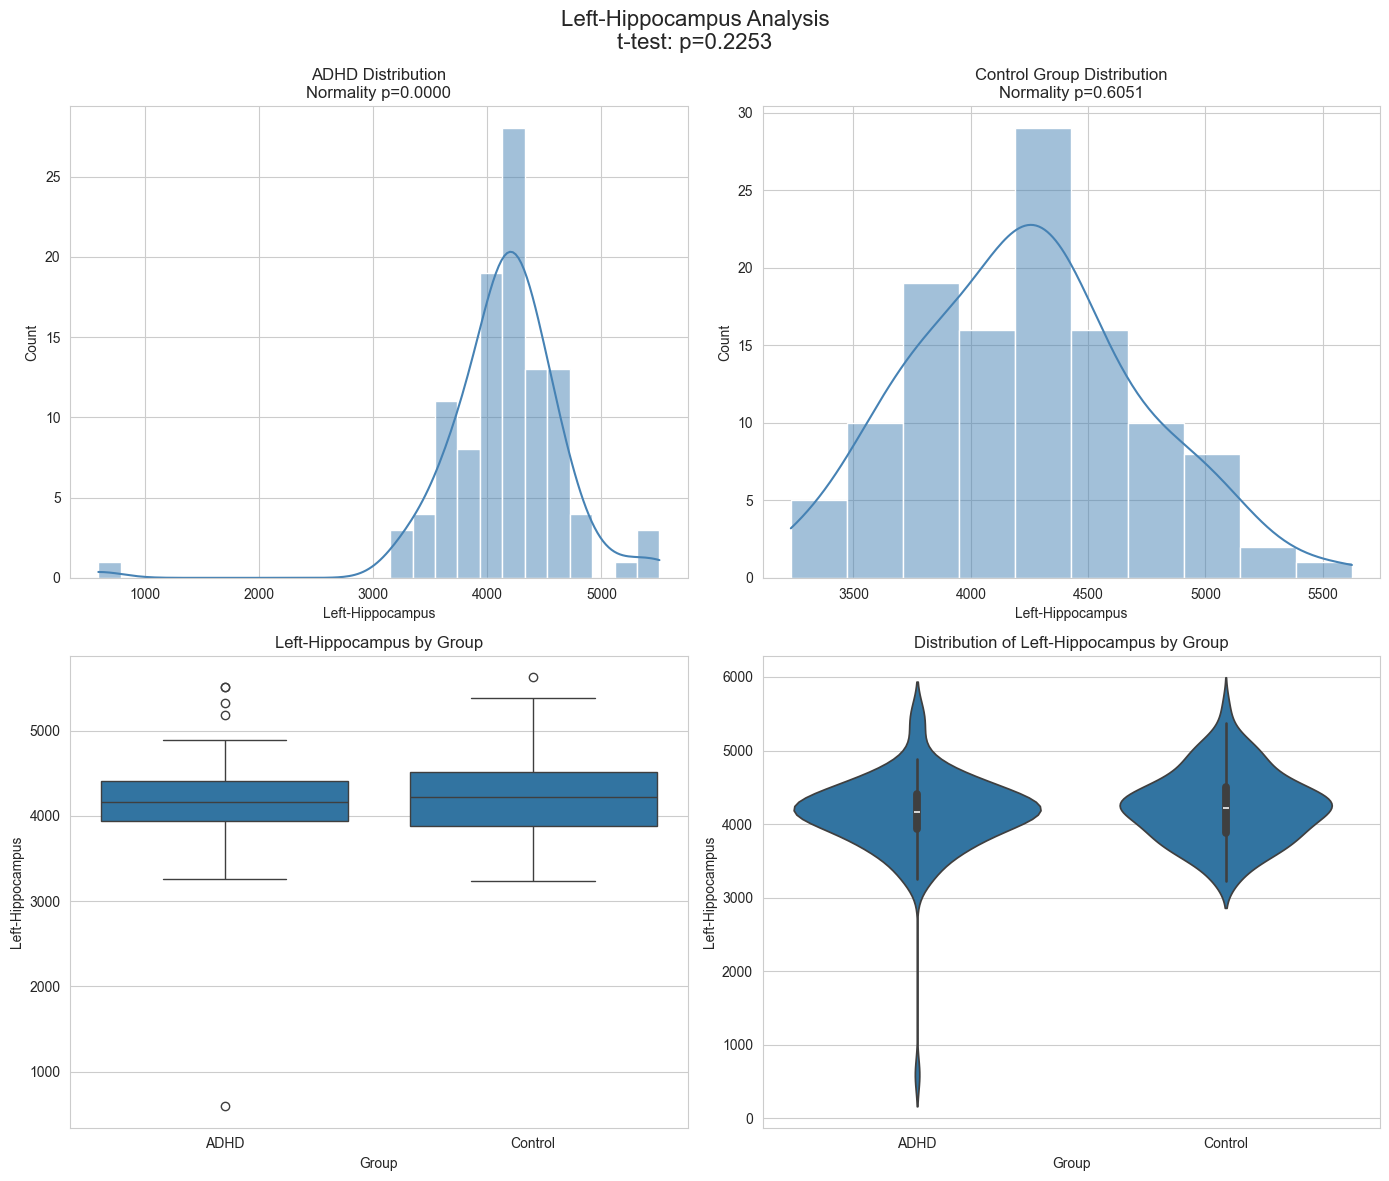

In [41]:
extract_stat_data('Left-Hippocampus')

stats.shapiro results:
	ADHD statistics: 0.9866424770306585. p-value: 0.35883611017501643
	Control statistics: 0.9889009461236097. p-value: 0.4668503354153341
T-test: t-statistic = -0.8656, p-value = 0.3877
Mann-Whitney U test: U-statistic = 5720.0000, p-value = 0.2621
Cohen's d effect size: 0.1157


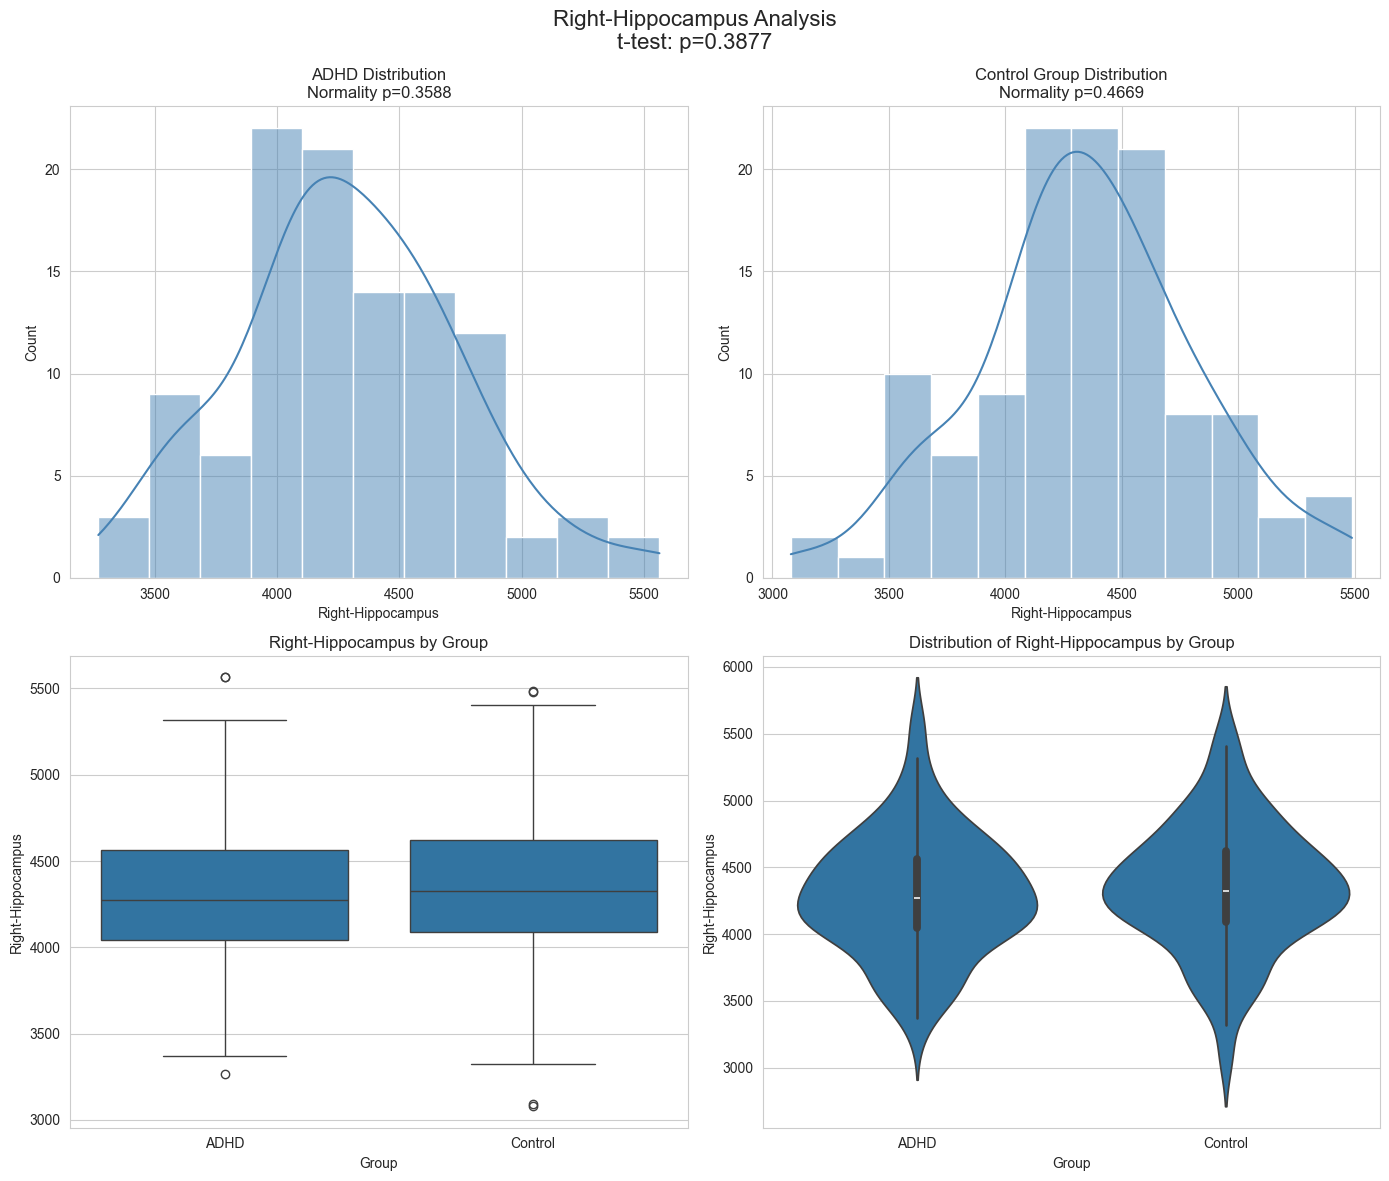

In [42]:
extract_stat_data('Right-Hippocampus')

In [43]:
import time
from statsmodels.stats.multitest import multipletests


def analyze_features_for_adhd(adhd_data,
                              control_data,
                              feature_names=None,
                              alpha=0.5,
                              correction_method='fdr_bh',
                              skip_threshold=50):
    """
    Comprehensive feature analysis for ADHD vs control subjects
    :param adhd_data: DataFrame containing data for ADHD subjects
    :param control_data: DataFrame containing data for control subjects
    :param feature_name: List of feature names to analyze (if None, uses all columns)
    :param alpha: Significance level for statistical tests
    :param correction_method: Multiple comparison correction method
    :return: DataFrame with feature analysis results sorted by importance
    """
    print(f"Analyzing {len(feature_names) if feature_names else 'all'} features...")
    start_time = time.time()

    # Use all columns if no feature_names provided
    if not feature_names:
        feature_names = adhd_data.columns

    # Prepare result dataframe list
    results = []

    for feature_name in feature_names:
        if feature_name not in adhd_data.columns or feature_name not in control_data.columns:
            print(f"Skipping {feature_name}")
            continue

        # Extract values
        adhd_values = adhd_data[feature_name].dropna()
        control_values = control_data[feature_name].dropna()

        # Skip feature with too few values
        if len(adhd_values) < skip_threshold or len(control_values) < skip_threshold:
            print(f"Skipping {feature_name} because there are less than {skip_threshold} observations")
            continue

        # Check normality
        _, adhd_norm_p = stats.shapiro(adhd_values) if len(adhd_values) <= 5000 else (0, 0)
        _, control_norm_p = stats.normaltest(control_values) if len(control_values) <= 5000 else (0, 0)

        # Determine if both are normally distributed (p > 0.05)
        # If the p-value is small, it means the observed results are unlikely to have occurred by
        # chance if the null hypothesis is true. This leads to the rejection of the null
        # hypothesis, suggesting there is evidence to support the alternative hypothesis.
        # A high p-value means the observed results are likely to have occurred by chance if the
        # null hypothesis is true. In this case, you fail to reject the null hypothesis, meaning
        # there's not enough evidence to conclude that there is a real effect or difference.
        is_normally_distributed = adhd_norm_p > 0.05 and  control_norm_p > 0.05

        if is_normally_distributed:
            # Check for equal variance
            _, levene_p = stats.levene(adhd_values, control_values)
            equal_variance = levene_p > 0.05

            # T-Test
            stat, p_value = stats.ttest_ind(adhd_values, control_values)
            test_name = "T-test (equal var)" if equal_variance else "T-test (unequal var)"
        else:
            # Mann-Whitney U Test
            stat, p_value = stats.mannwhitneyu(adhd_values, control_values)
            test_name = "Mann-Whitney U"

        # Calculate effect size (Cohen's d)
        n1, n2 = len(control_values), len(adhd_values)
        s1, s2 = control_values.std(), adhd_values.std()
        pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
        effect_size = (control_values.mean() - adhd_values.mean()) / pooled_std

        results.append({
            'feature': feature_name,
            'adhd_mean': adhd_values.mean(),
            'control_mean': control_values.mean(),
            'adhd_std': adhd_values.std(),
            'control_std': control_values.std(),
            'test': test_name,
            'statistic': stat,
            'p-value': p_value,
            'effect_size': effect_size,
            'abs_effect_size': abs(effect_size),
        })

    # Convert results list to dataframe
    result_data = pd.DataFrame(results)

    if not result_data.empty:
        # Apply multiple comparison correction
        _, corrected_p, _, _ = multipletests(result_data['p-value'], alpha=alpha, method=correction_method)
        result_data['Corrected_P_Value'] = corrected_p
        result_data['Significant'] = result_data['Corrected_P_Value'] < alpha

        # Sort by effect size (absolute) for significant features, then by p-value
        result_df = result_data.sort_values(by=['Significant', 'abs_effect_size', 'p-value'],
                                            ascending=[False, False, True])

    print(f"Analysis completed in {time.time() - start_time:.2f} seconds")
    return result_data

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def feature_importance_from_model(X, y, top_n=50):
    """

    :param X:
    :param y:
    :param top_n:
    :return:
    """
    # Create copies to avoid modifying original data
    X_copy = X.copy()
    y_copy = y.copy()

    # Get indices of rows without NaN values
    valid_indices = X_copy.dropna(axis=0, how='any').index

    # Filter X and y to keep only rows without NaN values
    X_filtered = X_copy.loc[valid_indices]
    y_filtered = y_copy.loc[valid_indices]

    print(f"Using {len(X_filtered)} out of {len(X_copy)} samples after removing NaN values")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ])

    # Fit the model
    pipeline.fit(X, y)

    # Extract feature importance
    importances = pipeline.named_steps['rf'].feature_importances_

    # Create DataFrame with feature importances
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False).reset_index(drop=True)

    return feature_importance.head(top_n)

In [45]:
def plot_top_features(result_df, top_n=20, show_plots=True):
    """
    Plot top features by effect size

    Parameters:
    -----------
    result_df : DataFrame with analysis results
    top_n : Number of top features to plot
    show_plots : Whether to display plots immediately

    Returns:
    --------
    Figure object
    """
    # Get top features - handle case where there are fewer features than top_n
    top_n = min(top_n, len(result_df))
    top_features = result_df.head(top_n)

    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot effect sizes
    sns.barplot(
        x='effect_size',
        y='feature',
        data=top_features,
        palette=['#d73027' if x < 0 else '#4575b4' for x in top_features['effect_size']],
        ax=axes[0]
    )
    axes[0].set_title(f'Top {top_n} Features by Effect Size', fontsize=16)
    axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[0].set_xlabel("Cohen's d Effect Size", fontsize=12)

    # Plot -log10(p-value)
    top_features['NegLog10P'] = -np.log10(top_features['p-value'])
    sns.barplot(
        x='NegLog10P',
        y='feature',
        data=top_features,
        ax=axes[1]
    )
    axes[1].set_title(f'Top {top_n} Features by Statistical Significance', fontsize=16)
    axes[1].axvline(x=-np.log10(0.05), color='red', linestyle='--', alpha=0.7)
    axes[1].set_xlabel('-log10(p-value)', fontsize=12)

    plt.tight_layout()

    if show_plots:
        plt.show()

In [46]:
adhd['adhd_binary'] = 1
adhd.head()


/var/folders/vx/61fdjmc15_jfzdhn6pw7sqgc0000gn/T/ipykernel_70664/2823100640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adhd['adhd_binary'] = 1


,subject_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary
0,sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,...,11197.0,1626.0,2100.0,875.0,5565.0,992979.0,1.0,9.16,ADHD,1
2,sub-0010029,9169.5,632.3,13238.4,55460.8,6471.6,4523.3,6335.9,1977.4,1161.6,...,11704.0,1919.0,1871.0,1277.0,5830.0,1126028.0,1.0,13.09,ADHD,1
3,sub-0010027,5143.7,632.3,11137.3,47115.4,6769.7,4062.3,5733.6,1574.8,524.0,...,12703.0,1407.0,1873.0,1251.0,6944.0,1061340.0,0.0,8.28,ADHD,1
4,sub-7333005,4499.2,681.2,15137.2,63323.7,8509.2,4692.6,6204.7,2005.6,931.3,...,12888.0,1465.0,2506.0,1233.0,8837.0,1221867.0,0.0,9.00,ADHD,1
5,sub-0010073,7199.9,672.3,15574.8,62408.3,8156.8,4700.1,6005.4,1919.4,996.2,...,12290.0,1390.0,2738.0,1016.0,6933.0,1285196.0,0.0,14.46,ADHD,1


In [47]:
control['adhd_binary'] = 0
# Get unique values in the column
print(control['diagnosis'].unique())

['Control']


/var/folders/vx/61fdjmc15_jfzdhn6pw7sqgc0000gn/T/ipykernel_70664/339841763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['adhd_binary'] = 0


In [48]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif


def run_feature_selection_analysis(adhd_df, control_df):

    # Create copies to avoid modifying the original dataframes
    adhd_df_copy = adhd_df.copy()
    control_df_copy = control_df.copy()

    # Get all feature names before filtering
    all_features = list(set(adhd_df_copy.columns) & set(control_df_copy.columns))
    total_features = len(all_features)

    # Find features with ANY NaN values in either dataframe
    print("Identifying features with NaN values...")
    adhd_has_nan = adhd_df_copy[all_features].isna().any()
    control_has_nan = adhd_df_copy[all_features].isna().any()

    # Features with NaN in either dataset
    features_with_nan = adhd_has_nan | control_has_nan

    # Get list of features without ANY NaN values
    features_without_nan = features_with_nan[~features_with_nan].index.tolist()
    print(f"Found {len(features_without_nan)} features out of {total_features} with NO missing values")

    # Keep only features without NaN values
    adhd_df_copy = adhd_df_copy[features_without_nan]
    control_df_copy = control_df_copy[features_without_nan]

    combined = pd.concat([adhd_df_copy, control_df_copy])
    # Extrac feature and target
    X = combined.drop('adhd_binary', axis=1)
    X = X.drop('diagnosis', axis=1)
    y = combined['adhd_binary']

    # Get feature names
    feature_names = X.columns.tolist()

    # Verify no NaN values remain
    if X.isna().any().any():
        raise ValueError("NaN values still present after filtering. Check your data.")

    # Statistical analysis
    print("Performing statistical analysis...")
    stat_results = analyze_features_for_adhd(adhd_df, control_df, feature_names)
    results = {'statistical_tests': stat_results}

    # Feature importance from model
    print("Computing feature importance from Random Forest model...")
    model_importance = feature_importance_from_model(X, y)

    # ANOVA F-value
    print("Running ANOVA feature selection...")
    selector = SelectKBest(f_classif, k='all')
    selector.fit(X, y)
    anova_scores = pd.DataFrame({
        'feature': X.columns,
        'f_score': selector.scores_,
        'p_value': selector.pvalues_
    }).sort_values('f_score', ascending=False).reset_index(drop=True)
    results['anova'] = anova_scores

    # Mutual Information
    print("Computing mutual information...")
    mi_scores = mutual_info_classif(X, y, random_state=42)
    mi_results = pd.DataFrame({
        'feature': X.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False).reset_index(drop=True)
    results['mutual_info'] = mi_results

    # Return all results
    return results

In [49]:
def visualize_common_features(results_dict, top_n=30):
    """
    Find and visualize common important features across different methods

    Parameters:
    -----------
    results_dict : Dictionary with analysis results
    top_n : Number of top features to consider from each method

    Returns:
    --------
    DataFrame with aggregated feature rankings
    """
    methods = list(results_dict.keys())
    all_rankings = {}

    # Get top features from each method
    for method, df in results_dict.items():
        feature_title = 'Feature' if 'Feature' in df.columns else 'feature'
        top_features = df.head(top_n)[feature_title].tolist()

        # Assign rank to each feature
        for i, feature in enumerate(top_features):
            if feature not in all_rankings:
                all_rankings[feature] = {}

            all_rankings[feature][method] = i + 1

    # Create DataFrame with rankings
    ranking_df = pd.DataFrame.from_dict(all_rankings, orient='index')
    ranking_df = ranking_df.fillna(top_n + 10)  # Fill missing with large rank

    # Add average rank
    ranking_df['avg_rank'] = ranking_df.mean(axis=1)

    # Sort by average rank
    ranking_df = ranking_df.sort_values('avg_rank')

    # Create count of methods that included this feature
    ranking_df['methods_count'] = (ranking_df < top_n + 1).sum(axis=1)

    # Plot top consensus features
    plt.figure(figsize=(12, 8))

    # Get top 20 consensus features
    top_consensus = ranking_df.head(20)

    # Create heatmap
    heatmap_data = top_consensus[methods].copy()

    # Convert ranks > top_n to NaN for better visualization
    for col in heatmap_data.columns:
        heatmap_data[col] = heatmap_data[col].apply(lambda x: x if x <= top_n else np.nan)

    # Plot heatmap
    sns.heatmap(
        heatmap_data,
        cmap='viridis_r',
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Rank (lower is better)'}
    )
    plt.title('Top Consensus Features Across Methods', fontsize=16)
    plt.tight_layout()
    plt.show()

    return ranking_df

In [50]:
adhd_copy = adhd.copy()
adhd_copy.reset_index(inplace=True)
adhd_copy=adhd_copy.drop('subject_id', axis=1)
control_copy = control.copy()
control_copy.reset_index(inplace=True)
control_copy=control_copy.drop('subject_id', axis=1)


In [51]:
adhd_copy.head()

,index,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary
0,0,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,...,11197.0,1626.0,2100.0,875.0,5565.0,992979.0,1.0,9.16,ADHD,1
1,2,9169.5,632.3,13238.4,55460.8,6471.6,4523.3,6335.9,1977.4,1161.6,...,11704.0,1919.0,1871.0,1277.0,5830.0,1126028.0,1.0,13.09,ADHD,1
2,3,5143.7,632.3,11137.3,47115.4,6769.7,4062.3,5733.6,1574.8,524.0,...,12703.0,1407.0,1873.0,1251.0,6944.0,1061340.0,0.0,8.28,ADHD,1
3,4,4499.2,681.2,15137.2,63323.7,8509.2,4692.6,6204.7,2005.6,931.3,...,12888.0,1465.0,2506.0,1233.0,8837.0,1221867.0,0.0,9.00,ADHD,1
4,5,7199.9,672.3,15574.8,62408.3,8156.8,4700.1,6005.4,1919.4,996.2,...,12290.0,1390.0,2738.0,1016.0,6933.0,1285196.0,0.0,14.46,ADHD,1


In [52]:
control_copy.head()

,index,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary
0,1,5304.9,418.0,12851.3,60354.1,6557.8,3832.1,5498.3,1498.4,763.9,...,11809.0,2032.0,1890.0,1030.0,5512.0,1062350.0,1.0,8.10,Control,0
1,6,11560.1,764.1,16638.9,58896.2,7053.3,3861.2,5576.7,1995.4,827.2,...,9543.0,1655.0,2567.0,779.0,6834.0,1116192.0,1.0,17.86,Control,0
2,8,7793.4,447.5,13483.3,59141.8,6995.5,3743.8,5741.5,1766.7,1147.2,...,10655.0,1870.0,2766.0,1143.0,7572.0,1135375.0,1.0,10.50,Control,0
3,12,3494.2,682.8,14809.8,67180.4,8794.2,4621.4,6752.3,1998.7,857.5,...,14783.0,2003.0,3232.0,1126.0,6854.0,1340866.0,0.0,11.32,Control,0
4,14,6341.3,599.6,11873.3,58635.5,6158.3,3310.5,5672.6,1646.3,983.1,...,10155.0,1496.0,1368.0,1111.0,4784.0,923022.0,1.0,8.16,Control,0


In [53]:
results = run_feature_selection_analysis(adhd_copy, control_copy)

Identifying features with NaN values...
Found 284 features out of 285 with NO missing values
Performing statistical analysis...
Analyzing 282 features...


/Users/stevenang/DataspellProjects/DataProcessing/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/vx/61fdjmc15_jfzdhn6pw7sqgc0000gn/T/ipykernel_70664/4158837541.py:74: RuntimeWarning: invalid value encountered in scalar divide
  effect_size = (control_values.mean() - adhd_values.mean()) / pooled_std


Analysis completed in 0.24 seconds
Computing feature importance from Random Forest model...
Using 440 out of 224 samples after removing NaN values
Running ANOVA feature selection...
Computing mutual information...


/Users/stevenang/DataspellProjects/DataProcessing/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 65 119 124 135 150 155 160 193 212 228 230 277] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/stevenang/DataspellProjects/DataProcessing/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [54]:
print(results)

{'statistical_tests':                            feature     adhd_mean  control_mean       adhd_std  \
0       lh_MeanThickness_thickness  1.174115e+06  1.169767e+06  117094.734346   
1      rh_medialorbitofrontal_area  3.838065e+03  3.861578e+03     610.667587   
2            rh_paracentral_volume  4.521676e+03  4.758931e+03     790.251218   
3    rh_medialorbitofrontal_volume  1.396568e+04  1.430007e+04    2174.424598   
4         lh_lateraloccipital_area  2.873583e+03  2.896750e+03     398.594027   
..                             ...           ...           ...            ...   
277   Right-non-WM-hypointensities  0.000000e+00  0.000000e+00       0.000000   
278  lh_inferiortemporal_thickness  2.404972e+00  2.459181e+00       0.182239   
279     rh_posteriorcingulate_area  5.096083e+03  5.084853e+03     592.306503   
280  rh_isthmuscingulate_thickness  2.284130e+00  2.319733e+00       0.104245   
281                    BrainSegVol  1.469356e+06  1.460237e+06  148135.054065   

     

In [55]:
results['statistical_tests']

,feature,adhd_mean,control_mean,adhd_std,control_std,test,statistic,p-value,effect_size,abs_effect_size,Corrected_P_Value,Significant
0,lh_MeanThickness_thickness,1.174115e+06,1.169767e+06,117094.734346,132763.590108,T-test (equal var),0.259201,0.795721,-0.034659,0.034659,0.984181,False
1,rh_medialorbitofrontal_area,3.838065e+03,3.861578e+03,610.667587,582.382217,Mann-Whitney U,5893.500000,0.445212,0.039439,0.039439,0.842616,False
2,rh_paracentral_volume,4.521676e+03,4.758931e+03,790.251218,898.012605,Mann-Whitney U,5304.000000,0.047733,0.279853,0.279853,0.289893,True
3,rh_medialorbitofrontal_volume,1.396568e+04,1.430007e+04,2174.424598,2192.609348,Mann-Whitney U,5602.000000,0.172294,0.153120,0.153120,0.578417,False
4,lh_lateraloccipital_area,2.873583e+03,2.896750e+03,398.594027,436.295470,T-test (equal var),-0.413938,0.679319,0.055350,0.055350,0.973287,False
...,...,...,...,...,...,...,...,...,...,...,...,...
277,Right-non-WM-hypointensities,0.000000e+00,0.000000e+00,0.000000,0.000000,Mann-Whitney U,6264.000000,1.000000,NaN,NaN,1.000000,False
278,lh_inferiortemporal_thickness,2.404972e+00,2.459181e+00,0.182239,0.148844,T-test (equal var),-2.445404,0.015248,0.326990,0.326990,0.124957,True
279,rh_posteriorcingulate_area,5.096083e+03,5.084853e+03,592.306503,627.256015,Mann-Whitney U,6135.500000,0.791701,-0.018390,0.018390,0.984181,False
280,rh_isthmuscingulate_thickness,2.284130e+00,2.319733e+00,0.104245,0.126109,T-test (unequal var),-2.293629,0.022747,0.306695,0.306695,0.156457,True


In [56]:
results['statistical_tests'][results['statistical_tests']['Significant'] == True]

,feature,adhd_mean,control_mean,adhd_std,control_std,test,statistic,p-value,effect_size,abs_effect_size,Corrected_P_Value,Significant
2,rh_paracentral_volume,4521.675926,4758.931034,790.251218,898.012605,Mann-Whitney U,5304.000000,0.047733,0.279853,0.279853,0.289893,True
5,rh_postcentral_thickness,2.437972,2.489129,0.151290,0.146128,Mann-Whitney U,5090.500000,0.015509,0.344172,0.344172,0.124957,True
13,lh_transversetemporal_volume,6973.777778,7424.698276,1128.163103,1265.640510,Mann-Whitney U,4846.500000,0.003459,0.375347,0.375347,0.036128,True
15,lh_posteriorcingulate_thickness,2.668194,2.702552,0.149405,0.134606,Mann-Whitney U,5219.000000,0.031150,0.242069,0.242069,0.204284,True
17,lh_postcentral_thickness,2.436769,2.513991,0.166425,0.181166,T-test (equal var),-3.314916,0.001071,0.443257,0.443257,0.014376,True
...,...,...,...,...,...,...,...,...,...,...,...,...
264,Right-Amygdala,1761.069444,1810.204310,212.488326,238.657915,T-test (equal var),-1.622882,0.106034,0.217005,0.217005,0.480709,True
267,Left-Cerebellum-White-Matter,14034.697222,13750.327586,2629.814127,2055.989010,Mann-Whitney U,7048.000000,0.105967,-0.121002,0.121002,0.480709,True
274,rh_transversetemporal_thickness,2.734241,2.870095,0.215423,0.236400,T-test (equal var),-4.484971,0.000012,0.599712,0.599712,0.000323,True
278,lh_inferiortemporal_thickness,2.404972,2.459181,0.182239,0.148844,T-test (equal var),-2.445404,0.015248,0.326990,0.326990,0.124957,True


/var/folders/vx/61fdjmc15_jfzdhn6pw7sqgc0000gn/T/ipykernel_70664/4087836665.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/vx/61fdjmc15_jfzdhn6pw7sqgc0000gn/T/ipykernel_70664/4087836665.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['NegLog10P'] = -np.log10(top_features['p-value'])


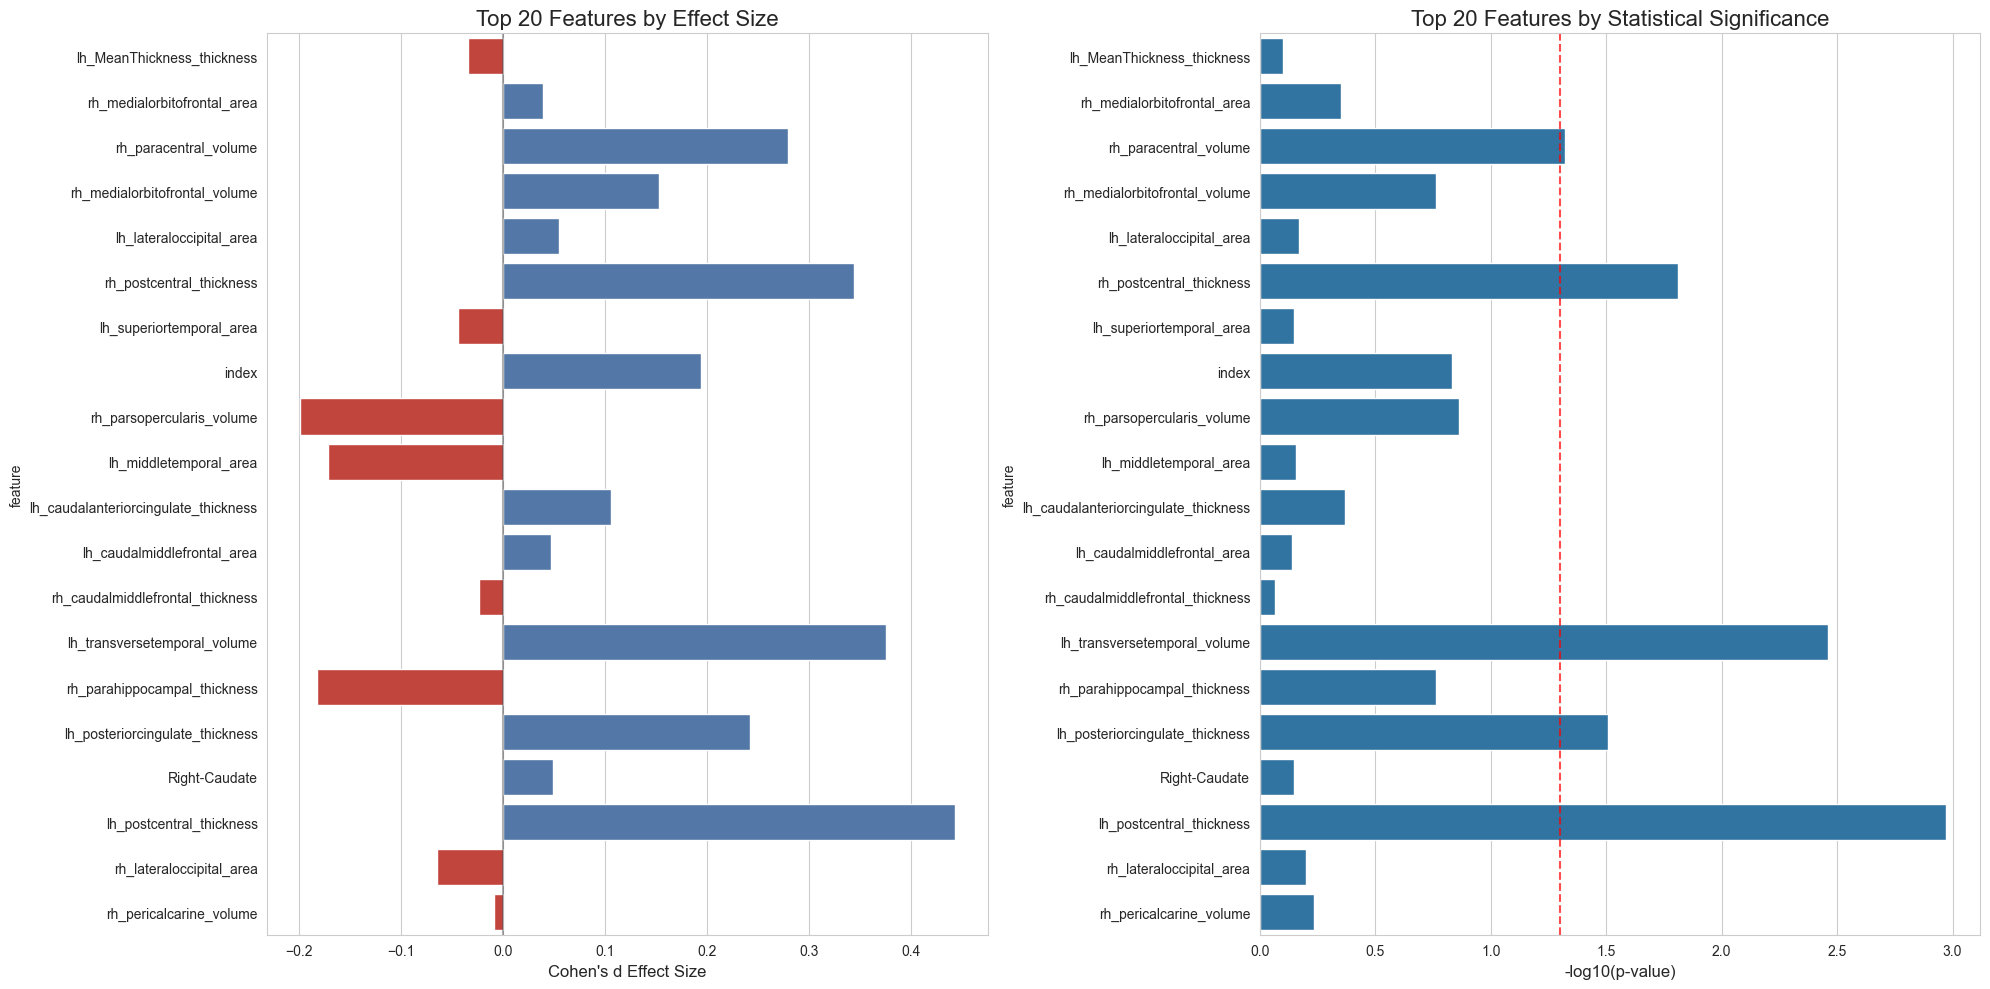

In [57]:
plot_top_features(results['statistical_tests'])

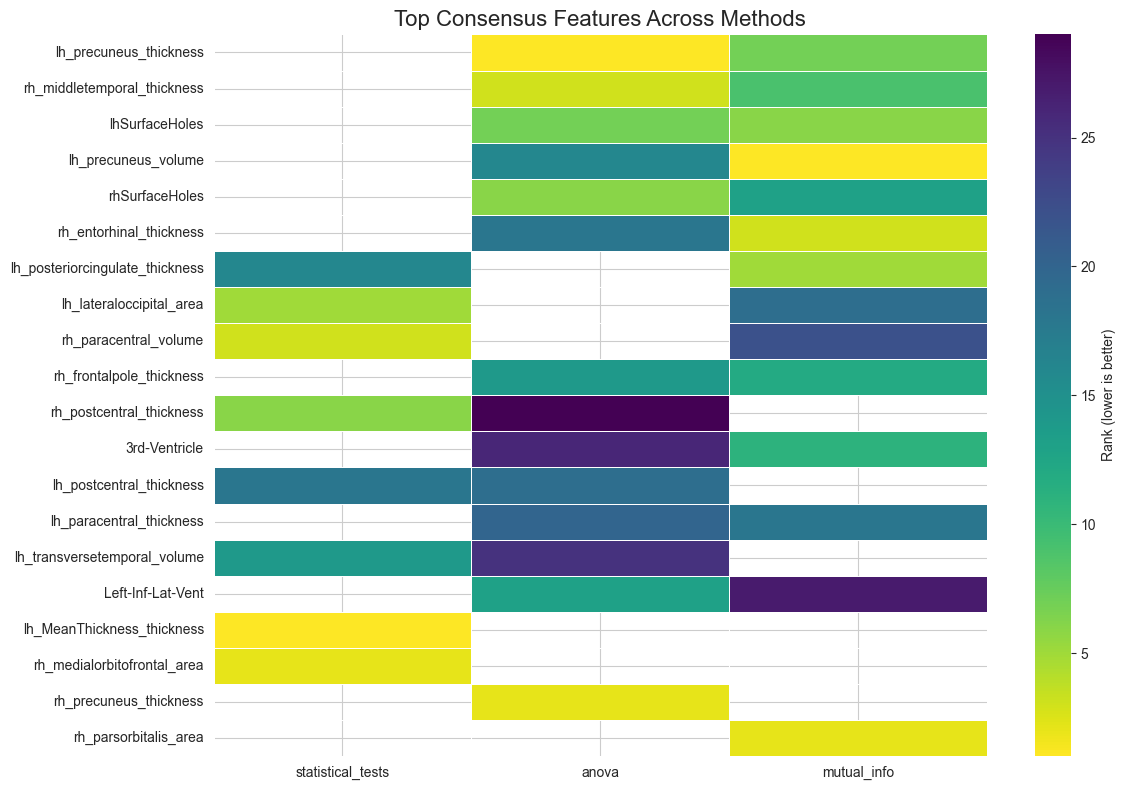

In [58]:
consensus_features = visualize_common_features(results)

In [59]:
print("Top 10 most important features for ADHD determination:")
print(consensus_features.head(10))

Top 10 most important features for ADHD determination:
                                 statistical_tests  mutual_info  anova  \
lh_precuneus_thickness                        40.0          7.0    1.0   
rh_middletemporal_thickness                   40.0          9.0    3.0   
lhSurfaceHoles                                40.0          6.0    7.0   
lh_precuneus_volume                           40.0          1.0   16.0   
rhSurfaceHoles                                40.0         13.0    6.0   
rh_entorhinal_thickness                       40.0          3.0   18.0   
lh_posteriorcingulate_thickness               16.0          5.0   40.0   
lh_lateraloccipital_area                       5.0         19.0   40.0   
rh_paracentral_volume                          3.0         22.0   40.0   
rh_frontalpole_thickness                      40.0         12.0   14.0   

                                  avg_rank  methods_count  
lh_precuneus_thickness           16.000000              3  
rh_middlet